In [132]:
import warnings, pickle, os, itertools

import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 300)

from IPython.display import display
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(rc={'figure.figsize':(10,10)})
plt.rc("axes", titlesize=14, labelsize=14)
plt.rc('figure', titlesize=16)

import shap
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from utils.evaluation import *
from models import *
from systematic_comparison import get_xy
%aimport utils.evaluation, models, systematic_comparison

In [134]:
class Notebook:
    SYS_RESULTS_DIR = 'models/systematic_comparison/'
    TIME_RESULTS_DIR = 'models/time_tough_with_h1_filtered/'
    TIME_PERSISTED_RESULTS_DIR = 'models/time_far_short'
    IMAGE_DIR = 'images/revision/'

def load_results(directory, exclude=['OneClassSVM', 'IsolationForest']):
    result_files = [f'{directory}/{_}' for _ in os.listdir(directory) if _.endswith('.h5')]
    y_preds = pd.concat([pd.read_hdf(_, 'y_preds') for _ in result_files], axis=1)
    metrics = pd.concat([pd.read_hdf(_, 'metrics') for _ in result_files], axis=0).reset_index(drop=True)
    # hyperparameters = {name: optuna.load_study(study_name = name, storage=Notebook.STORAGE).best_params for name in metrics.name.values}

    if len(exclude):
        metrics = metrics[~metrics.estimator.isin(exclude)].copy()
        y_preds = y_preds[metrics.name.values].copy()

    return metrics, y_preds

def load_model(name, directory):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        with open(f'{directory}/models/{name}.bin', 'rb') as file:
            return pickle.load(file)

In [183]:
from sklearn.model_selection import train_test_split
from dataset import SCIData, SCICols
%aimport dataset

sci = SCIData.load('data/sci.h5')

scii = (
    SCIData(
        SCIData.quickload("data/sci_processed.h5").sort_values("AdmissionDateTime")
    )
    .mandate(SCICols.news_data_raw)
    .augment_shmi(onehot=True)
    .derive_ae_diagnosis_stems(onehot=False)
    .derive_critical_event(within=1, return_subcols=True)
)
scii = SCIData(scii[
    (~((scii.BreathingDevice=='NIV - NIV')&(scii.AdmitWard=='HH1M'))) #&
    (~scii.AdmissionMethodDescription.isin(['BOOKED ADMISSION ', 'ELECTIVE PLANNED']))
].copy())

sci_train, sci_test = train_test_split(
    scii,
    test_size=0.33,
    random_state=42,
    shuffle=False,
)

sci_test = sci_test[(
  #  (~((scii.BreathingDevice=='NIV - NIV')&(scii.AdmitWard=='HH1M'))) &
    (~sci_test.AdmissionMethodDescription.isin(['BOOKED ADMISSION ', 'ELECTIVE PLANNED']))
) & (sci_test.Age >= 18)]

sci_test_precovid = sci_test[sci_test.AdmissionDateTime < '2020-03-01']
sci_train, sci_test = SCIData(sci_train), SCIData(sci_test)


In [136]:
select_num_cols = dict(
    Age='Age (years)', 
    TotalLOS='LOS (days)',
  #  ReadmissionTimespan='Readmission',
    NEWS_score='NEWS',
    O2_saturation='SpO2 (%)',
    Respiration_rate='RR (breaths/min)',
    HeartRate='Pulse (beats/min)',
    SystolicBP='Systolic BP (mmHg)',
    DiastolicBP='Diastolic BP (mmHg)',
    Temperature='Temperature (oC)',
    Haemoglobin='Haemoglobin (g/L)',
    Urea_serum='Urea (mmol/L)',
    Sodium_serum='Sodium (mmol/L)',
    Potassium_serum='Potassium (mEg/L)',
    Creatinine='Creatinine (mmol/L)',
    Oxygen_flow_rate='FiO2 (%)'
)
select_binary_cols = dict(
    DiedWithin30Days = '30-day Mortality',
    DiedDuringStay = 'In-hospital Mortality',
    AVCPU_Alert = 'AVCPU-A',
    AssistedBreathing = 'Assisted Breathing',
    Female='Female',
    LyingDown='Lying Down',
    Nausea='Nausea',
    Pain='Pain',
    VomitingSinceLastRound='Vomiting',
    Readmission='Readmission',
    SentToSDEC='SDEC'
)
select_feature_groups = dict(
    news='Vitals',
    news_with_phenotype='& Obs',
    with_labs='& Labs',
    with_notes_and_labs='& Notes',
    with_notes_labs_and_hospital='& Services'
)
select_scored_feature_groups = dict(
    news_scores='Vitals',
    news_scores_with_phenotype='& Obs',
    scores_with_labs='& Labs',
    scores_with_notes_and_labs='& Notes',
    scores_with_notes_labs_and_hospital='& Services'
)
pretty_print_models = dict(
    LogisticRegression='LR',
    L1Regression='LR-L1',
    L2Regression='LR-L2',
    ElasticNetRegression='LR-EN',
    XGBoost='XGBoost',
    LightGBM='LightGBM',
    LinearSVM='LinearSVM'
)
select_categorical_cols = dict(
    AdmissionMethodDescription='Admission Pathway',
    AdmissionSpecialty='Admission Specialty',
    AandEPresentingComplaint='Presenting Complaint',
    BreathingDevice='Breathing Device',
    AandEMainDiagnosis='A&E Diagnosis'
)
pretty_print_categoricals = {
    'collaps': 'collaps-',
    'dizz': 'dizz-',
    'BOOKED ADMISSION ': 'Booked Adm.',
    'EMERGENCY OPD': 'Emg. OPD',
    'EMERGENCY A+E': 'Emg. A&E',
    'EMERGENCY GP REFER': 'Emg. GP Ref.',
    'NON EM TRAN OTH PROV': 'Non-Emg. Transf.',
    'ACCIDENT & EMERGENCY': 'A&E',
    'ACUTE INTERNAL MEDICINE': 'Acute Int. Med.',
    'GENERAL SURGERY': 'Gen. Surgery',
    'NEPHROLOGY': 'Nephrology',
    'TRAUMA & ORTHOPAEDICS': 'Trauma & Ortho.',
    'EMERG TRAN OTH PROV': 'Emg. Tran. Oth. Prov.',
    'ELECTIVE PLANNED': 'Elective Booked',
    'GENERAL MEDICINE': 'General Med.',
    'RESPIRATORY MEDICINE': 'Respiratory Med.',
    'GERIATRIC MEDICINE': 'Geriatric Med.',
    'BARIATRIC SURGERY': 'Bariatric Surg.',
    'SPINAL SURGERY SERVICE': 'Spinal Surg. Svc.',
    'GASTROENTEROLOGY': 'Gastro.',
    'NEUROSURGERY': 'Neurosurgery',
    'UROLOGY': 'Urology',
    'STROKE NEUROLOGY': 'Stroke Neuro.',
    'GYNAECOLOGY': 'Gyno.',
    'abscesses and local infections': 'local infections'
}

In [190]:
unseen_idx = sci_test[~sci_test.PatientNumber.isin(sci_train.PatientNumber)].index
seen_idx = sci_test[sci_test.PatientNumber.isin(sci_train.PatientNumber)].index

## Dataset

In [206]:
def summarise_numerical_variables():
    df = SCIData(scii.copy())

    dfs = {
        'Total': df,
        'Train.': df.loc[sci_train.index],
        'Valid. (Complete)': df.loc[sci_test.index],
        'Valid. (Unseen)': df.loc[unseen_idx],
        'Valid. (Pre-Covid)': df.loc[sci_test_precovid.index]
    }

    groups = {
        'Vitals': scii.feature_groups['news'] + ['NEWS_score'],
        'Supplemental Observations & Phenotype': scii.feature_groups['news_extended'] + scii.feature_groups['phenotype'],
        'Labs': scii.feature_groups['labs'],
        'Service Utilisation': scii.feature_groups['hospital'],
        'Outcomes': ['DiedDuringStay', 'DiedWithin30Days', 'CriticalCare', 'CriticalEvent'],
        'Episode':['TotalLOS']
    }

    bin_cols = select_binary_cols | {
        'CriticalCare': 'Critical Care',
        'CriticalEvent': 'Critical Events'
    }
    group_lookup = {}
    for name, group in groups.items():
        group_lookup.update({_:name for _ in group})

    r = [dict(
            Dataset=dfname,
            Variable=vname,
            Group=group_lookup[vcol],
            Summary=f'{df[vcol].median():.2f} ({df[vcol].quantile(0.25):.2f}-{df[vcol].quantile(0.75):.2f})'.replace('.00','')
        ) for vcol, vname in select_num_cols.items() for dfname, df in dfs.items()] + [dict(
            Dataset=dfname,
            Variable=vname,
            Group=group_lookup[vcol],
            Summary=f'{df[vcol].sum()} ({df[vcol].sum()/df[vcol].shape[0]*100:.2f}%)'.replace('.00', '')
        ) for vcol, vname in bin_cols.items() for dfname, df in dfs.items()]
    
    for dfname, df in dfs.items():
        r += [dict(
            Dataset=dfname,
            Variable='Records',
            Group='Episode',
            Summary=df.shape[0]
        ), dict(
            Dataset=dfname,
            Variable='Patients',
            Group='Episode',
            Summary=df.PatientNumber.unique().shape[0]
        )]
    
    return pd.DataFrame(r).pivot(index=['Group', 'Variable'], columns='Dataset', values='Summary').loc[['Episode', 'Outcomes', 'Vitals', 'Supplemental Observations & Phenotype', 'Labs', 'Service Utilisation']][['Total', 'Training', 'Test (Complete)', 'Test (Unseen)', 'Test (Pre-Covid)']]
    

r = summarise_numerical_variables()
r

Dataset                                                                 Total  \
Group                                 Variable                                  
Episode                               LOS (days)             2.27 (0.65-7.13)   
                                      Patients                          62162   
                                      Records                          121058   
Outcomes                              30-day Mortality           3967 (3.28%)   
                                      Critical Care              2593 (2.14%)   
                                      Critical Events            2893 (2.39%)   
                                      In-hospital Mortality      5124 (4.23%)   
Vitals                                AVCPU-A                 119493 (98.71%)   
                                      Assisted Breathing       12167 (10.05%)   
                                      NEWS                            1 (0-2)   
                                      Pulse (beats/min)            80 (70-90)   
                                      RR (breaths/min)             17 (16-18)   
                                      SpO2 (%)                     97 (96-98)   
                                      Systolic BP (mmHg)        124 (113-139)   
                                      Temperature (oC)       36.70 (36.40-37)   
Supplemental Observations & Phenotype Age (years)                  69 (50-82)   
                                      Diastolic BP (mmHg)          70 (60-80)   
                                      Female                   63414 (52.38%)   
                                      FiO2 (%)                        0 (0-0)   
                                      Lying Down               56565 (46.73%)   
                                      Nausea                     1934 (1.60%)   
                                      Pain                   18504.0 (15.29%)   
                                      Vomiting                    607 (0.50%)   
Labs                                  Creatinine (mmol/L)         79 (63-105)   
                                      Haemoglobin (g/L)         130 (114-143)   
                                      Potassium (mEg/L)      4.20 (3.90-4.50)   
                                      Sodium (mmol/L)           138 (135-140)   
                                      Urea (mmol/L)          6.40 (4.60-9.60)   
Service Utilisation                   Readmission              15387 (12.71%)   
                                      SDEC                     29096 (24.03%)   

Dataset                                                              Training  \
Group                                 Variable                                  
Episode                               LOS (days)             2.06 (0.63-6.68)   
                                      Patients                          44752   
                                      Records                           81108   
Outcomes                              30-day Mortality           2589 (3.19%)   
                                      Critical Care              1825 (2.25%)   
                                      Critical Events            2021 (2.49%)   
                                      In-hospital Mortality      3233 (3.99%)   
Vitals                                AVCPU-A                  80013 (98.65%)   
                                      Assisted Breathing         7835 (9.66%)   
                                      NEWS                            1 (0-2)   
                                      Pulse (beats/min)            80 (70-90)   
                                      RR (breaths/min)             17 (16-18)   
                                      SpO2 (%)                     97 (96-98)   
                                      Systolic BP (mmHg)        122 (112-138)   
                                      Temperature (oC)       36.70 (36.40-37)   
Supplemental Observations & Ph

In [208]:
#print(r.to_latex(multirow=True, column_format='llrrrrr', bold_rows=True))

In [34]:
select_num_cols_values = {
    _:scii[_] for _ in select_num_cols.keys()
} | dict(
    Oxygen_flow_rate = scii.Oxygen_flow_rate*100
   # ReadmissionTimespan = scii.ReadmissionTimespan.dt.days
)

pd.DataFrame([{
    'Variable': select_num_cols[k],
    'Mean +- Std': f'{v.mean():.2f} ± {v.std():.2f}',
    'Min': round(v.min(), 2),
    'Max': round(v.max(), 2)
} for k, v in select_num_cols_values.items()]).set_index('Variable')


,Mean +- Std,Min,Max
Variable,,,
Age (years),64.99 ± 20.48,0.0,121.00
LOS (days),6.82 ± 14.96,0.0,1491.17
NEWS,1.20 ± 1.67,0.0,18.00
SpO2 (%),96.58 ± 2.55,48.0,100.00
RR (breaths/min),17.67 ± 2.50,7.0,77.00
Pulse (beats/min),80.85 ± 15.42,26.0,194.00
Systolic BP (mmHg),126.74 ± 19.71,52.0,270.00
Diastolic BP (mmHg),70.15 ± 12.40,22.0,198.00
Temperature (oC),36.76 ± 0.51,30.8,41.10


In [204]:
def summarise_categorical_variables():
    df = SCIData(scii.copy())
    for col in select_categorical_cols.keys():
        if col != 'AandEMainDiagnosis':
            df.loc[(~df[col].isin(df[col].value_counts().head(5).index)) & df[col].notna(), col] = 'Other'
    
    df['BreathingDevice'] = df.BreathingDevice.str.split(' - ').str[1]
    df.loc[df.AandEPresentingComplaint == 'abdominal pain in adults', 'AandEPresentingComplaint'] = 'abd. pain'
    df.loc[df.AandEPresentingComplaint == 'shortness of breath in adults', 'AandEPresentingComplaint'] = 'short. breath'
    

    dfs = {
        'Total': df,
        'Train.': df.loc[sci_train.index],
        'Valid. (Complete)': df.loc[sci_test.index],
        'Valid. (Unseen)': df.loc[unseen_idx],
        'Valid. (Pre-Covid)': df.loc[sci_test_precovid.index]
    }

    r = [(df[vcol].value_counts().astype(str) + ' ('+
        (df[vcol].value_counts()/df[vcol].shape[0]*100).round(2).astype(str)+'%)')
        .to_frame(name='Summary')
        .reset_index()
        .assign(Variable=vname, Dataset=dfname)
        .rename(columns=dict(index='Value')).to_dict(orient='records')
        for vcol, vname in select_categorical_cols.items() for dfname, df in dfs.items()
    ]

    r = pd.DataFrame([__ for _ in r for __ in _])
    r.Value = r.Value.replace(pretty_print_categoricals)
    return r.pivot(
        index=['Variable', 'Value'], columns='Dataset', values='Summary'
        ).fillna("0 (0%)")[['Total', 'Training', 'Test (Complete)', 'Test (Unseen)', 'Test (Pre-Covid)']].loc[[
            'Admission Pathway', 'Admission Specialty', 'Breathing Device', 'Presenting Complaint', 'A&E Diagnosis'
        ]]

r = summarise_categorical_variables()
r

Dataset                                          Total        Training  \
Variable             Value                                               
Admission Pathway    Booked Adm.          1807 (1.49%)     899 (1.11%)   
                     Emg. A&E          110627 (91.38%)  74530 (91.89%)   
                     Emg. GP Ref.         5866 (4.85%)     3733 (4.6%)   
                     Emg. OPD              898 (0.74%)     631 (0.78%)   
                     Non-Emg. Transf.     1180 (0.97%)     792 (0.98%)   
                     Other                 680 (0.56%)     523 (0.64%)   
Admission Specialty  A&E                18319 (15.13%)  12891 (15.89%)   
                     Acute Int. Med.    91025 (75.19%)   59212 (73.0%)   
                     Gen. Surgery         2612 (2.16%)    2395 (2.95%)   
                     Nephrology           3454 (2.85%)    2281 (2.81%)   
                     Other                4415 (3.65%)    3334 (4.11%)   
                     Trauma & Ortho.      1233 (1.02%)     995 (1.23%)   
Breathing Device     Air               108851 (89.92%)  73233 (90.29%)   
                     Nasal cannula        8900 (7.35%)    5547 (6.84%)   
                     Reservoir mask        394 (0.33%)     221 (0.27%)   
                     Simple mask           685 (0.57%)     308 (0.38%)   
                     Venturi 28%           391 (0.32%)     349 (0.43%)   
Presenting Complaint Other              36819 (30.41%)  26077 (32.15%)   
                     abd. pain             6413 (5.3%)    4514 (5.57%)   
                     chest pain          11585 (9.57%)    7633 (9.41%)   
                     falls                5278 (4.36%)    3421 (4.22%)   
                     other              31485 (26.01%)  21565 (26.59%)   
                     short. breath      14865 (12.28%)   9337 (11.51%)   
A&E Diagnosis        collaps-             1245 (1.03%)    1245 (1.53%)   
                     confus                356 (0.29%)     356 (0.44%)   
                     cope                  592 (0.49%)     348 (0.43%)   
                     dementia              227 (0.19%)       85 (0.1%)   
                     diarrh                326 (0.27%)      325 (0.4%)   
                     dizz-                  89 (0.07%)      89 (0.11%)   
                     fall                 1461 (1.21%)     1461 (1.8%)   
                     head                 2704 (2.23%)    1992 (2.46%)   
                     mobility              102 (0.08%)     102 (0.13%)   
                     pain                 7162 (5.92%)     7139 (8.8%)   
                     sudden                   1 (0.0%)        1 (0.0%)   
                     tight                    5 (0.0%)       5 (0.01%)   
                     vomit                 296 (0.24%)     264 (0.33%)   

Dataset                               Test (Complete)   Test (Unseen)  \
Variable             Value                                              
Admission Pathway    Booked Adm.               0 (0%)          0 (0%)   
                     Emg. A&E          36015 (92.63%)  20379 (91.16%)   
                     Emg. GP Ref.        2128 (5.47%)    1491 (6.67%)   
                     Emg. OPD             266 (0.68%)     148 (0.66%)   
                     Non-Emg. Transf.      387 (1.0%)     278 (1.24%)   
                     Other                 83 (0.21%)      60 (0.27%)   
Admission Specialty  A&E                 5404 (13.9%)   3738 (16.72%)   
                     Acute Int. Med.    31104 (80.0%)   17080 (76.4%)   
                     Gen. Surgery         216 (0.56%)     145 (0.65%)   
                     Nephrology           897 (2.31%)     547 (2.45%)   
                     Other               1025 (2.64%)     704 (3.15%)   
                     Trauma & Ortho.       233 (0.6%)     142 (0.64%)   
Breathing Device     Air               34566 (88.91%)  20125 (90.02%)   
                     Nasal cannula       3340 (8.59%)    1645 (7.36%)   
                   

In [209]:
#print(r.to_latex(multirow=True, bold_rows=True, column_format='llrrrrr'))

In [37]:
select_categorical_cols_values = {
    _:scii[_] for _ in select_categorical_cols.keys()
} | dict(
)

In [38]:
pd.concat([(
    (v.value_counts().head(5).astype(str) + ' ('+
    (v.value_counts().head(5)/v.shape[0]*100).round(2).astype(str)+'%)')
    .to_frame(name='n (%)')
    .reset_index()
    .assign(Column=select_categorical_cols[k])
    .set_index(['Column', 'index'])
) for k, v in select_categorical_cols_values.items()])

n (%)
Column               index                                         
Admission Pathway    EMERGENCY A+E                  110627 (91.38%)
                     EMERGENCY GP REFER                5866 (4.85%)
                     BOOKED ADMISSION                  1807 (1.49%)
                     NON EM TRAN OTH PROV              1180 (0.97%)
                     EMERGENCY OPD                      898 (0.74%)
Admission Specialty  ACUTE INTERNAL MEDICINE         91025 (75.19%)
                     ACCIDENT & EMERGENCY            18319 (15.13%)
                     NEPHROLOGY                        3454 (2.85%)
                     GENERAL SURGERY                   2612 (2.16%)
                     TRAUMA & ORTHOPAEDICS             1233 (1.02%)
Presenting Complaint other                           31485 (26.01%)
                     shortness of breath in adults   14865 (12.28%)
                     chest pain                       11585 (9.57%)
                     abdominal pain in adults           6413 (5.3%)
                     falls                             5278 (4.36%)
Breathing Device     A - Air                        108851 (89.92%)
                     N - Nasal cannula                 8900 (7.35%)
                     SM - Simple mask                   685 (0.57%)
                     RM - Reservoir mask                394 (0.33%)
                     V28 - Venturi 28%                  391 (0.32%)
A&E Diagnosis        pain                              7162 (5.92%)
                     head                              2704 (2.23%)
                     fall                              1461 (1.21%)
                     collaps                           1245 (1.03%)
                     cope                               592 (0.49%)

In [442]:
print(f'Patients appearing in both: {np.isin(sci_train.PatientNumber.unique(), sci_test.PatientNumber.unique()).sum()}={np.isin(sci_train.PatientNumber.unique(), sci_test.PatientNumber.unique()).sum()/scii.PatientNumber.unique().shape[0]*100:.2f}%')
print(f'Number of episodes: {sci_test.PatientNumber.isin(sci_train.PatientNumber).sum()} = {sci_test.PatientNumber.isin(sci_train.PatientNumber).sum()/sci_test.shape[0]*100:.2f}%')


Patients appearing in both: 8070=12.98%
Number of episodes: 16523 = 42.50%


In [40]:
df = sci_train.groupby('PatientNumber').AdmissionDateTime.max().to_frame().join(
    sci_test.groupby('PatientNumber').AdmissionDateTime.min(), lsuffix='_train', rsuffix='_test'
).dropna()
num = (df.AdmissionDateTime_test - df.AdmissionDateTime_train < pd.Timedelta(days=30)).sum()
print(f'Patients where this happened within 30 days: {num} = {num/scii.PatientNumber.unique().shape[0]*100:.2f}%')

Patients where this happened within 30 days: 64 = 0.10%


In [41]:
pd.DataFrame(
    [
        dict(
            Subset=name,
            Start=df.AdmissionDateTime.min().strftime('%Y-%m-%d'),
            End=df.AdmissionDateTime.max().strftime('%Y-%m-%d'),
            Records=df.shape[0],
            Patients=df.PatientNumber.unique().shape[0],
            CriticalEvents=f'{df.CriticalEvent.sum()} ({round(df.CriticalEvent.sum()/df.shape[0]*100,2)}%)',
            Deaths=f'{df.DiedWithinThreshold.sum()} ({round(df.DiedWithinThreshold.sum()/df.shape[0]*100,2)}%)',
            CriticalCare=f'{df.CriticalCare.sum()} ({round(df.CriticalCare.sum()/df.shape[0]*100,2)}%)',
            Readmissions=f'{df.Readmission.sum()} ({round(df.Readmission.sum()/df.shape[0]*100,2)}%)',
        )
        for name, df in {
            'Training Set': sci_train, 
            'Testing Set': sci_test, 
            'Testing Set - Unseen': sci_test[~sci_test.PatientNumber.isin(sci_train.PatientNumber)],
            'Testing Set - Revisits': sci_test[sci_test.PatientNumber.isin(sci_train.PatientNumber)],
            'Total': scii
        }.items()
    ]
).set_index('Subset').T

Subset,Training Set,Testing Set,Testing Set - Unseen,Testing Set - Revisits,Total
Start,2015-01-01,2019-08-10,2019-08-10,2019-08-10,2015-01-01
End,2019-08-10,2022-03-31,2022-03-31,2022-03-31,2022-03-31
Records,81108,39950,23075,16875,121058
Patients,44752,25549,17410,8139,62162
CriticalEvents,2021 (2.49%),872 (2.18%),515 (2.23%),357 (2.12%),2893 (2.39%)
Deaths,219 (0.27%),116 (0.29%),65 (0.28%),51 (0.3%),335 (0.28%)
CriticalCare,1825 (2.25%),768 (1.92%),458 (1.98%),310 (1.84%),2593 (2.14%)
Readmissions,10732 (13.23%),4655 (11.65%),1919 (8.32%),2736 (16.21%),15387 (12.71%)


In [194]:
import matplotlib.cm as cm
def plot_clustered_stacked(dfall, labels=None, legend_titles=[None, None], title="multiple stacked bar plot",  H=['','//', "XX", '..'], **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""

    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    sns.set_style('whitegrid')

    axe = plt.subplot(111)

    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      linewidth=0,
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      **kwargs)  # make bar plots

    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
    for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
        for j, pa in enumerate(h[i:i+n_col]):
            for rect in pa.patches: # for each index
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                rect.set_hatch(H[int(i / n_col)]) #edited part     
                rect.set_width(1 / float(n_df + 1))

    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 0)
    axe.set_title(title)

    # Add invisible data to add another legend
    n=[]        
    for i in range(n_df):
        n.append(axe.bar(0, 0, color="gray", hatch=H[i]))
    plt.grid(axis='y')
    l1 = axe.legend(h[:n_col], l[:n_col], loc=[1.01, 0.5], frameon=False, title=legend_titles[0])
    if labels is not None:
        l2 = plt.legend(n, labels, loc=[1.01, 0.1], frameon=False, title=legend_titles[1]) 
    axe.add_artist(l1)
    return axe

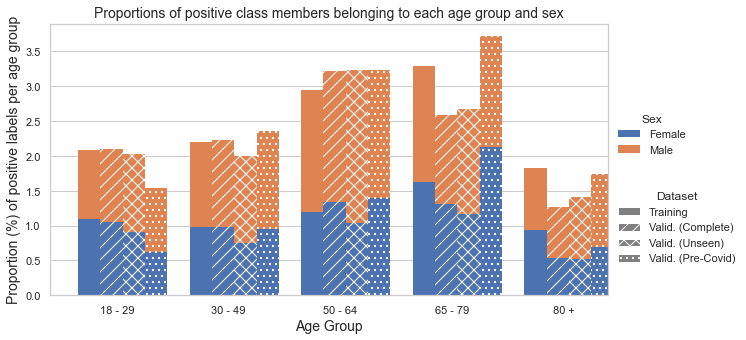

In [198]:
def agesex_barplot(save=None):
    fig, ax = plt.subplots(1,1, figsize=(10, 5))
    dfs = {
        'Training': sci_train,
        'Valid. (Complete)': sci_test,
        'Valid. (Unseen)': sci_test.loc[unseen_idx],
        'Valid. (Pre-Covid)': sci_test_precovid
    }
    for name, df in dfs.items():
        df = df[['AgeBand', 'Female', 'CriticalEvent']].copy()
        series = df.Female.copy()
        df.loc[series, 'Female'] = 'Female'
        df.loc[~series, 'Female'] = 'Male'
        df.loc[df.AgeBand == '17 - 29', 'AgeBand'] = '18 - 29'
        df = df.groupby(['AgeBand', 'Female']).CriticalEvent.sum()/df.groupby(['AgeBand']).CriticalEvent.count()*100
        df = df.drop('16 and Under', level=0, errors='ignore').reset_index().pivot(columns=['Female'], values=['CriticalEvent'], index='AgeBand').CriticalEvent
        dfs[name] = df
    plot_clustered_stacked(list(dfs.values()), list(dfs.keys()), ['Sex', 'Dataset'], title='Proportions of positive class members belonging to each age group and sex')
    ax.set_xlabel('Age Group')
    ax.set_ylabel('Proportion (%) of positive labels per age group')
    if save:
        plt.savefig(save, bbox_inches="tight", format='svg')


agesex_barplot(save=f'{Notebook.IMAGE_DIR}/age_sex_bars.svg')

In [199]:
scii.AandEPresentingComplaint.value_counts().sum()/scii.shape[0]

0.8792892663021031

## NEWS

In [262]:
news_performance_thresholds = {n: get_metrics(
        sci_test.derive_critical_event(within=t, return_series=True),
        sci_test.NEWS_score >= 7,
        sci_test.NEWS_score
    ) for t, n in [(1, '24h'), (2, '48h'), (999, 'Any')]}
baseline_news_performance = news_performance_thresholds['24h']

In [45]:
functions = {
    'Critical Event': sci_test.derive_critical_event,
    'Mortality':sci_test.derive_death_within,
    'Critical Care': sci_test.derive_critical_care,
}
thresholds = {
    '24h': 1,
    '48h': 2,
    'Any': 999
}

news_performances = [
    (outcome_name, threshold_name, get_metrics(
        function(within=threshold, return_series=True),
        sci_test.NEWS_score >= 7,
        sci_test.NEWS_score
    )) for (outcome_name, function) in functions.items() for (threshold_name, threshold) in thresholds.items()
]
pd.DataFrame([dict(
    Outcome=o,
    Threshold=t,
    AUC=f"{v['AUC']:.2f} ({v['AUC_Lower']:.2f}-{v['AUC_Upper']:.2f})",
    AP=f"{v['AP']:.2f} ({v['AP_Lower']:.2f}-{v['AP_Upper']:.2f})",
) for o, t, v in news_performances])

,Outcome,Threshold,AUC,AP
0,Critical Event,24h,0.80 (0.78-0.82),0.15 (0.13-0.17)
1,Critical Event,48h,0.82 (0.80-0.83),0.23 (0.20-0.25)
2,Critical Event,Any,0.76 (0.76-0.78),0.30 (0.28-0.32)
3,Mortality,24h,0.93 (0.90-0.96),0.17 (0.13-0.23)
4,Mortality,48h,0.92 (0.89-0.94),0.26 (0.21-0.31)
5,Mortality,Any,0.77 (0.76-0.78),0.23 (0.22-0.26)
6,Critical Care,24h,0.78 (0.76-0.80),0.09 (0.08-0.10)
7,Critical Care,48h,0.79 (0.77-0.80),0.11 (0.10-0.13)
8,Critical Care,Any,0.76 (0.75-0.77),0.11 (0.10-0.13)


## Metrics

In [214]:
from scipy import stats as st
from sklearn.metrics import roc_auc_score, average_precision_score
def bootstrap_difference(y_true, y_score, y_idx, metric, n_resamples=99):
    diff = lambda yt, ys, idx: metric(y_true=yt, y_score=ys) - metric(y_true=yt[idx.astype(bool)], y_score=ys[idx.astype(bool)])
    center = diff(y_true, y_score, y_idx)
    res = st.bootstrap(
        data=(y_true.to_numpy(), y_score, y_idx),
        statistic=diff,
        confidence_level=0.95,
        method="percentile",
        n_resamples=n_resamples,
        vectorized=False,
        paired=True,
        random_state=42,
    )

    return res.confidence_interval.low, center, res.confidence_interval.high

def calculate_metric_diff(y_true, y_preds, y_idx, metrics):
    r = []
    for _ in metrics.to_dict(orient='records'):
        ap_low, ap, ap_up = bootstrap_difference(y_true, y_preds[_['name']], y_idx, average_precision_score)
        auc_low, auc, auc_up = bootstrap_difference(y_true, y_preds[_['name']], y_idx, roc_auc_score)
        r.append(_|dict(
            AP = ap,
            AP_Lower = ap_low,
            AP_Upper = ap_up,
            AUC = auc,
            AUC_Lower = auc_low,
            AUC_Upper = auc_up
        ))

    return pd.DataFrame(r)

def recalc_metrics(y_idx, y_true, y_preds, metrics):
    y_true, y_preds = y_true.loc[y_idx], y_preds.loc[y_idx]
    return pd.DataFrame((
        _|get_metrics(y_true, y_preds[_['name']]>0.1, y_preds[_['name']])
        for _ in metrics.to_dict(orient='records')
    ))



In [417]:
METRICS, Y_PREDS = load_results(Notebook.SYS_RESULTS_DIR)
Y_PREDS = Y_PREDS.dropna().loc[sci_test.index]

met, ypr = load_results('models/systematic_select_long')
METRICS[METRICS.estimator=='LinearSVM'] = met[met.estimator=='LinearSVM']
Y_PREDS[met[met.estimator=='LinearSVM'].name] = ypr[met[met.estimator=='LinearSVM'].name]


In [233]:
# METRICS = (
#     recalc_metrics(sci_test.index, sci_test.CriticalEvent, Y_PREDS, METRICS)
# )

# METRICS_PRECOVID, PRECOVID_METRIC_DIFF = (
#     recalc_metrics(sci_test_precovid.index, sci_test.CriticalEvent, Y_PREDS, METRICS),
#     calculate_metric_diff(sci_test.CriticalEvent, Y_PREDS.loc[sci_test.index], sci_test.AdmissionDateTime < '2020-03-01' , METRICS)
# )

# METRICS_UNSEEN, UNSEEN_METRIC_DIFF = (
#     recalc_metrics(unseen_idx, sci_test.CriticalEvent, Y_PREDS, METRICS),
#     calculate_metric_diff(sci_test.CriticalEvent, Y_PREDS.loc[sci_test.index], ~sci_test.PatientNumber.isin(sci_train.PatientNumber), METRICS)
# )

# with open(f'{Notebook.SYS_RESULTS_DIR}/metrics.bin', 'wb') as file:
#     pickle.dump(METRICS, file)

# with open(f'{Notebook.SYS_RESULTS_DIR}/metrics_unseen.bin', 'wb') as file:
#     pickle.dump((METRICS_UNSEEN, UNSEEN_METRIC_DIFF), file)

# with open(f'{Notebook.SYS_RESULTS_DIR}/metrics_precovid.bin', 'wb') as file:
#     pickle.dump((METRICS_PRECOVID, PRECOVID_METRIC_DIFF), file)

with open(f'{Notebook.SYS_RESULTS_DIR}/metrics.bin', 'rb') as file:
    METRICS = pickle.load(file)

with open(f'{Notebook.SYS_RESULTS_DIR}/metrics_unseen.bin', 'rb') as file:
    METRICS_UNSEEN, UNSEEN_METRIC_DIFF = pickle.load(file)

with open(f'{Notebook.SYS_RESULTS_DIR}/metrics_unseen.bin', 'rb') as file:
    METRICS_PRECOVID, PRECOVID_METRIC_DIFF = pickle.load(file)

In [234]:
print(UNSEEN_METRIC_DIFF.AUC.median())
print(UNSEEN_METRIC_DIFF.AP.median())

-0.008040452481696103
-0.048141227450117424


In [498]:
print(PRECOVID_METRIC_DIFF.AUC.median())
print(PRECOVID_METRIC_DIFF.AP.median())

0.010116497448245498
-0.003758580065566633


### Tables

In [53]:
def summary_metrics_tables(metrics, estimators=['LightGBM', 'L2Regression']):
    df = metrics[
        (metrics.estimator.isin(estimators)) & 
        (metrics.features.isin(select_feature_groups.keys())) & 
        (metrics.resampler == 'None')
    ]
    #df = METRICS.loc[METRICS[METRICS.estimator.isin(['LightGBM', 'L1Regression', 'LinearSVM']) & METRICS.features.isin(select_feature_groups.keys())].groupby(['estimator', 'features']).AUC.idxmax()]

    for estimator in ['LightGBM', 'L2Regression'] :
        display(pd.DataFrame([dict(
            Estimator=_['estimator'],
            Features=select_feature_groups[_['features']],
            AUC=f"{_['AUC']:.2f} ({_['AUC_Lower']:.2f}-{_['AUC_Upper']:.2f})",
            AP=f"{_['AP']:.2f} ({_['AP_Lower']:.2f}-{_['AP_Upper']:.2f})"
        ) for _ in df[df.estimator==estimator].to_dict(orient='records')]))

summary_metrics_tables(METRICS)

,Estimator,Features,AUC,AP
0,LightGBM,Vitals,0.83 (0.82-0.85),0.18 (0.16-0.21)
1,LightGBM,& Obs,0.87 (0.85-0.88),0.31 (0.28-0.35)
2,LightGBM,& Labs,0.89 (0.88-0.90),0.31 (0.28-0.35)
3,LightGBM,& Notes,0.89 (0.88-0.90),0.32 (0.29-0.36)
4,LightGBM,& Services,0.92 (0.91-0.93),0.51 (0.48-0.55)


,Estimator,Features,AUC,AP
0,L2Regression,Vitals,0.81 (0.80-0.83),0.16 (0.13-0.18)
1,L2Regression,& Obs,0.84 (0.82-0.85),0.26 (0.23-0.29)
2,L2Regression,& Labs,0.84 (0.82-0.85),0.26 (0.23-0.29)
3,L2Regression,& Notes,0.85 (0.84-0.87),0.26 (0.23-0.29)
4,L2Regression,& Services,0.89 (0.88-0.91),0.47 (0.43-0.50)


In [501]:
((sci_test.NEWS_score >= 7) & sci_test.CriticalEvent).sum()

192

In [504]:
sci_test[sci_test.NEWS_score >= 7].DiedDuringStay.sum()

326

In [422]:
def summary_metrics_unseen_comparison(metrics, metrics_unseen, metrics_precovid, estimators=['LightGBM', 'L2Regression']):
    mask = lambda df: df[
        (df.estimator.isin(estimators)) & 
        (df.features.isin(select_feature_groups.keys())) & 
        (df.resampler == 'None')
    ]
    dfs = [('1 Complete', metrics), ('2 Unseen', metrics_unseen), ('3 Pre-Covid', metrics_precovid)]
    df = pd.DataFrame((dict(
            Metric=metric,
            Estimator=pretty_print_models[_['estimator']],
            Features=select_feature_groups[_['features']],
            #Value=f"{_[metric]:.2f} ({_[metric+'_Lower']:.2f}-{_[metric+'_Upper']:.2f})",
            Value=f"{_[metric]:.3f}",
            Dataset=dataset,
        )) for dataset, df in dfs for metric in ('AUC', 'AP') for _ in mask(df).to_dict(orient='records')
    ).sort_values(['Metric', 'Estimator', 'Dataset']).set_index(['Metric', 'Estimator', 'Dataset', 'Features']).unstack()['Value'][select_feature_groups.values()]
    df.columns = list(df.columns)
    df.index = df.index.set_levels(df.index.levels[2].str.split(' ').str[1], level=2)
    return df


summary = summary_metrics_unseen_comparison(METRICS, METRICS_UNSEEN, METRICS_PRECOVID)
summary
#

Vitals  & Obs & Labs & Notes & Services
Metric Estimator Dataset                                          
AP     LR-L2     Complete   0.157  0.259  0.261   0.265      0.469
                 Unseen     0.173  0.311  0.308   0.314      0.483
                 Pre-Covid  0.163  0.249  0.250   0.259      0.518
       LightGBM  Complete   0.180  0.314  0.314   0.324      0.516
                 Unseen     0.206  0.371  0.366   0.375      0.529
                 Pre-Covid  0.201  0.330  0.331   0.354      0.578
AUC    LR-L2     Complete   0.810  0.835  0.838   0.850      0.893
                 Unseen     0.821  0.842  0.844   0.853      0.896
                 Pre-Covid  0.806  0.830  0.821   0.839      0.897
       LightGBM  Complete   0.832  0.866  0.887   0.889      0.921
                 Unseen     0.840  0.877  0.895   0.896      0.922
                 Pre-Covid  0.831  0.867  0.876   0.877      0.919

In [423]:
#print(summary.to_latex(bold_rows=True, escape=False, column_format='lll|ccccc', multirow=True, formatters=[lambda x: f'${x}$' for _ in range(5)]))

In [256]:
def news_summary_metrics():
    y_test = sci_test.derive_critical_event(within=1, return_series=True)
    metrics = [get_metrics(
        y_test,
        sci_test.NEWS_score >= 7,
        sci_test.NEWS_score
    ), get_metrics(
        y_test.loc[unseen_idx],
        sci_test.loc[unseen_idx].NEWS_score >= 7,
        sci_test.loc[unseen_idx].NEWS_score
    ), get_metrics(
        y_test.loc[sci_test_precovid.index],
        sci_test_precovid.NEWS_score >= 7,
        sci_test_precovid.NEWS_score
    )]  
    metrics = [_|dict(
        name='NEWS2',
        estimator='NEWS2',
        resampler=None,
        features='NEWS2',
        outcome_within=1
    ) for _ in metrics]
   # metrics_diff = calculate_metric_diff(y_test, {'NEWS2': sci_test.NEWS_score}, ~sci_test.PatientNumber.isin(sci_train.PatientNumber), pd.DataFrame(metrics[0], index=[0])).to_dict(orient='records')[0]

    dfs = {'Valid. (Complete)': metrics[0], 'Valid. (Unseen)': metrics[1], 'Valid. (Pre-Covid)': metrics[2]}
    r = [dict(
        Data=dfname,
        Metric=metric,
        Estimator=_['estimator'],
        Features=_['features'],
        Summary=f'{_[metric]:.4f} ({_[metric+"_Lower"]:.4f}-{_[metric + "_Upper"]:.4f})',
    ) for dfname, _ in dfs.items() for metric in ('AUC', 'AP')]
    return r

In [441]:
r.AP['Valid. (Complete)']['NEWS2']

Estimator
NEWS2    0.1470 (0.1286-0.1674)
Name: Valid. (Complete), dtype: object

In [437]:
r.AP['Valid. (Complete)'].max()

'0.5163 (0.4835-0.5524)'

In [424]:
def summary_metrics_unseen_comparison(metrics, metrics_unseen, metrics_precovid):
    dfs = {'Valid. (Complete)': metrics, 'Valid. (Unseen)': metrics_unseen, 'Valid. (Pre-Covid)': metrics_precovid}
    dfs = {k: v[(v.resampler=='None')&(v.features.isin(select_feature_groups.keys()))] for k, v in dfs.items()}
    group_names = select_feature_groups | select_scored_feature_groups
    r = [dict(
        Data=dfname,
        Metric=metric,
        Estimator=pretty_print_models[_['estimator']],
        Features=group_names[_['features']],
        Summary=f'{_[metric]:.4f} ({_[metric+"_Lower"]:.4f}-{_[metric + "_Upper"]:.4f})',
    ) for dfname, df in dfs.items() for _ in df.to_dict(orient='records') for metric in ('AUC', 'AP')]
    r = news_summary_metrics() + r
    return pd.DataFrame(r).pivot(index=['Features', 'Estimator'], columns=['Metric', 'Data'], values='Summary').loc[['NEWS2', 'Vitals', '& Obs', '& Labs', '& Notes', '& Services']][['AUC', 'AP']]

r = summary_metrics_unseen_comparison(METRICS, METRICS_UNSEEN, METRICS_PRECOVID)#.set_index(['Estimator', 'Features', 'Metric', 'Data', 'Resampler'])
r

Metric                                   AUC                          \
Data                       Valid. (Complete)         Valid. (Unseen)   
Features   Estimator                                                   
NEWS2      NEWS2      0.7965 (0.7783-0.8125)  0.8101 (0.7919-0.8295)   
Vitals     LR         0.8098 (0.7925-0.8277)  0.8206 (0.8017-0.8432)   
           LR-EN      0.8086 (0.7914-0.8264)  0.8200 (0.8009-0.8431)   
           LR-L1      0.8098 (0.7926-0.8277)  0.8206 (0.8015-0.8433)   
           LR-L2      0.8098 (0.7925-0.8278)  0.8206 (0.8017-0.8432)   
           LightGBM   0.8325 (0.8141-0.8481)  0.8398 (0.8188-0.8587)   
           LinearSVM  0.8047 (0.7846-0.8245)  0.8140 (0.7948-0.8395)   
           XGBoost    0.8360 (0.8189-0.8528)  0.8457 (0.8266-0.8631)   
& Obs      LR         0.8347 (0.8194-0.8501)  0.8417 (0.8279-0.8605)   
           LR-EN      0.8349 (0.8195-0.8503)  0.8419 (0.8283-0.8606)   
           LR-L1      0.8348 (0.8194-0.8502)  0.8419 (0.8281-0.8608)   
           LR-L2      0.8347 (0.8193-0.8501)  0.8417 (0.8279-0.8605)   
           LightGBM   0.8663 (0.8476-0.8806)  0.8773 (0.8640-0.8933)   
           LinearSVM  0.7994 (0.7794-0.8122)  0.8085 (0.7851-0.8309)   
           XGBoost    0.8670 (0.8505-0.8813)  0.8776 (0.8646-0.8911)   
& Labs     LR         0.8377 (0.8236-0.8529)  0.8444 (0.8287-0.8619)   
           LR-EN      0.8379 (0.8240-0.8528)  0.8445 (0.8289-0.8620)   
           LR-L1      0.8453 (0.8327-0.8615)  0.8521 (0.8374-0.8700)   
           LR-L2      0.8376 (0.8236-0.8528)  0.8444 (0.8287-0.8619)   
           LightGBM   0.8870 (0.8745-0.9013)  0.8949 (0.8823-0.9091)   
           LinearSVM  0.7987 (0.7784-0.8142)  0.8065 (0.7886-0.8280)   
           XGBoost    0.8802 (0.8674-0.8949)  0.8890 (0.8748-0.9020)   
& Notes    LR         0.8475 (0.8336-0.8620)  0.8521 (0.8361-0.8696)   
           LR-EN      0.8499 (0.8370-0.8642)  0.8527 (0.8368-0.8706)   
           LR-L1      0.8548 (0.8425-0.8699)  0.8587 (0.8428-0.8761)   
           LR-L2      0.8496 (0.8370-0.8640)  0.8527 (0.8365-0.8702)   
           LightGBM   0.8894 (0.8780-0.9036)  0.8960 (0.8853-0.9081)   
           LinearSVM  0.8172 (0.8010-0.8321)  0.8305 (0.8127-0.8498)   
           XGBoost    0.8830 (0.8720-0.8950)  0.8895 (0.8765-0.9031)   
& Services LR         0.8905 (0.8784-0.9034)  0.8926 (0.8817-0.9091)   
           LR-EN      0.8932 (0.8814-0.9055)  0.8954 (0.8836-0.9124)   
           LR-L1      0.8946 (0.8831-0.9068)  0.8974 (0.8858-0.9138)   
           LR-L2      0.8934 (0.8817-0.9056)  0.8957 (0.8838-0.9130)   
           LightGBM   0.9209 (0.9115-0.9313)  0.9218 (0.9114-0.9326)   
           LinearSVM  0.8593 (0.8471-0.8770)  0.8601 (0.8399-0.8783)   
           XGBoost    0.9114 (0.9000-0.9227)  0.9125 (0.8999-0.9248)   

Metric                                                            AP  \
Data                      Valid. (Pre-Covid)       Valid. (Complete)   
Features   Estimator                                                   
NEWS2      NEWS2      0.7693 (0.7263-0.8037)  0.1470 (0.1286-0.1674)   
Vitals     LR         0.8061 (0.7728-0.8371)  0.1570 (0.1367-0.1794)   
           LR-EN      0.8053 (0.7712-0.8366)  0.1552 (0.1345-0.1780)   
           LR-L1      0.8061 (0.7728-0.8371)  0.1568 (0.1365-0.1791)   
           LR-L2      0.8061 (0.7728-0.8371)  0.1570 (0.1367-0.1793)   
           LightGBM   0.8306 (0.7985-0.8553)  0.1796 (0.1579-0.2055)   
           LinearSVM  0.8057 (0.7704-0.8364)  0.1605 (0.1397-0.1832)   
           XGBoost    0.8309 (0.7996-0.8616)  0.1715 (0.1517-0.1955)   
& Obs      LR         0.8297 (0.7999-0.8571)  0.2593 (0.2287-0.2995)   
           LR-EN      0.8299 (0.8001-0.8572)  0.2586 (0.2284-0.2981)   
           LR-L1      0.8298 (0.8000-0.8570)  0.2579 (0.2271-0.2977)   
           LR-L2      0.8297 (0.7998-0.8572)  0.2588 (0.2286-0.2987)   
           LightGBM   0.8675 (0.8390-0.8926)  0.3142 (0.2763-0.3479)   
           LinearSVM  0.7976 (0.7684-0.

In [426]:
print(r['AUC'].to_latex(bold_rows=True, multirow=True, multicolumn=True, longtable=False, column_format='llrrrrrr'))

\begin{tabular}{llrrrrrr}
\toprule
           & \textbf{Data} &       Valid. (Complete) &         Valid. (Unseen) &      Valid. (Pre-Covid) \\
\textbf{Features} & \textbf{Estimator} &                         &                         &                         \\
\midrule
\textbf{NEWS2} & \textbf{NEWS2} &  0.7965 (0.7783-0.8125) &  0.8101 (0.7919-0.8295) &  0.7693 (0.7263-0.8037) \\
\multirow{7}{*}{\textbf{Vitals}} & \textbf{LR} &  0.8098 (0.7925-0.8277) &  0.8206 (0.8017-0.8432) &  0.8061 (0.7728-0.8371) \\
           & \textbf{LR-EN} &  0.8086 (0.7914-0.8264) &  0.8200 (0.8009-0.8431) &  0.8053 (0.7712-0.8366) \\
           & \textbf{LR-L1} &  0.8098 (0.7926-0.8277) &  0.8206 (0.8015-0.8433) &  0.8061 (0.7728-0.8371) \\
           & \textbf{LR-L2} &  0.8098 (0.7925-0.8278) &  0.8206 (0.8017-0.8432) &  0.8061 (0.7728-0.8371) \\
           & \textbf{LightGBM} &  0.8325 (0.8141-0.8481) &  0.8398 (0.8188-0.8587) &  0.8306 (0.7985-0.8553) \\
           & \textbf{LinearSVM} &  0.8047 (0.784

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


### Bar Plots

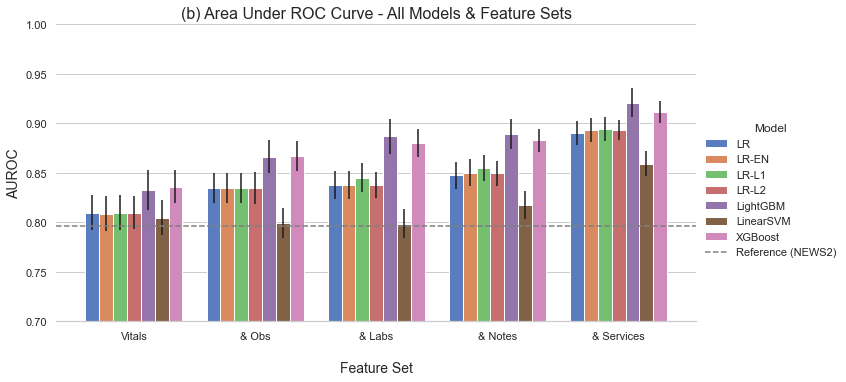

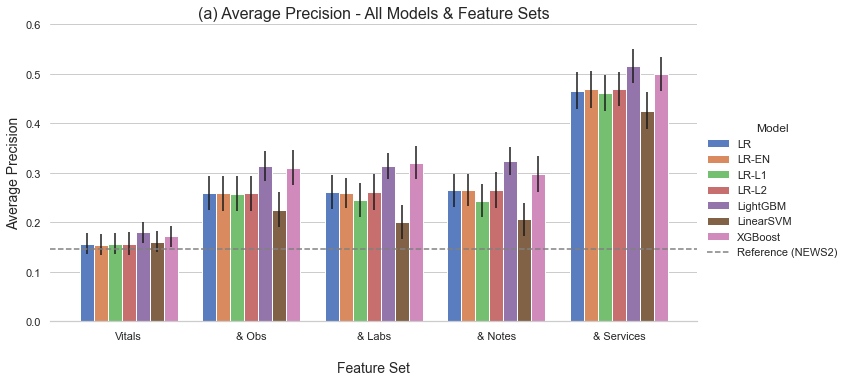

In [427]:
def select_feature_ablation_barplot(metrics, feature_groups, metric='AUC', ylim=(0.0, 1.0), ylabel=None, baseline=None, title=None, save=None):
    sns.set_style('whitegrid')
    df = metrics[
        (metrics.features.isin(feature_groups.keys()))
        & (metrics.resampler == 'None')
    ].rename(columns=dict(
        features='Features',
        estimator='Model'
    ))
    err = (df[f'{metric}_Upper']-df[f'{metric}_Lower'])/2
    df['Features'] = pd.Categorical(df.Features.replace(feature_groups), ordered=True, categories=feature_groups.values())
    df['Model'] = df.Model.replace(pretty_print_models)
    g = sns.catplot(
        data=df.sort_values(['Model','Features']), x='Features', y=metric, hue='Model',
        kind='bar', palette='muted', height=6, orient='v', legend=False
    )
    g.despine(left=True)
    g.fig.set_size_inches(10,5)
    g.ax.set_ylim(ylim)
    x_coords = [p.get_x() + 0.5*p.get_width() for p in g.ax.patches]
    y_coords = [p.get_height() for p in g.ax.patches]
    g.ax.errorbar(x=x_coords, y=y_coords, yerr=err, fmt="none", c= "k")

    if baseline is not None:
        g.refline(y = baseline[metric], color = 'gray', linestyle = '--', label = "Reference (NEWS2)") 
        g.add_legend(title='Model')
    
    g.set_xlabels("Feature Set", labelpad=20)
    g.ax.set_title(title, fontsize=16)
    if ylabel:
        g.set_ylabels(ylabel)
    if metric=='AUC':
        g.set_ylabels('AUROC')
    if save:
        plt.savefig(save, bbox_inches="tight", format='svg')

select_feature_ablation_barplot(METRICS, select_feature_groups, 'AUC', (0.7, 1.0), baseline=baseline_news_performance, ylabel='AUC', title='(b) Area Under ROC Curve - All Models & Feature Sets', save=f'{Notebook.IMAGE_DIR}/auc_bar.svg')
select_feature_ablation_barplot(METRICS, select_feature_groups, 'AP', (0.0, 0.6), baseline=baseline_news_performance, ylabel='Average Precision', title='(a) Average Precision - All Models & Feature Sets', save=f'{Notebook.IMAGE_DIR}/ap_bar.svg')

In [532]:
def select_feature_ablation_barplot(metrics, feature_groups, metric='AUC', ylim=(0.0, 1.0), ylabel=None, baseline=None, title=None, save=None):
    sns.set_style('whitegrid')
    df = metrics[
        (metrics.features.isin(feature_groups.keys()))
        & (metrics.resampler == 'None')
    ].rename(columns=dict(
        features='Features',
        estimator='Model'
    ))
    err = (df[f'{metric}_Upper']-df[f'{metric}_Lower'])/2
    df['Features'] = pd.Categorical(df.Features.replace(feature_groups), ordered=True, categories=feature_groups.values())
    df['Model'] = df.Model.replace(pretty_print_models)
    g = sns.catplot(
        data=df.sort_values(['Model','Features']), x='Features', y=metric, hue='Model',
        kind='bar', palette='muted', height=6, orient='v', legend=False
    )
    g.despine(left=True)
    g.fig.set_size_inches(9,3)
    g.ax.set_ylim(ylim)
    x_coords = [p.get_x() + 0.5*p.get_width() for p in g.ax.patches]
    y_coords = [p.get_height() for p in g.ax.patches]
    g.ax.errorbar(x=x_coords, y=y_coords, yerr=err, fmt="none", c= "k")

    if baseline is not None:
        g.refline(y = baseline[metric], color = 'gray', linestyle = '--', label = "Reference (NEWS2)") 
        g.add_legend(title='Model')
    
    g.set_xlabels("Feature Set", labelpad=20)
    g.ax.set_title(title, fontsize=16)
    if ylabel:
        g.set_ylabels(ylabel)
    if metric=='AUC':
        g.set_ylabels('AUROC')
    if save:
        plt.savefig(save, bbox_inches="tight")

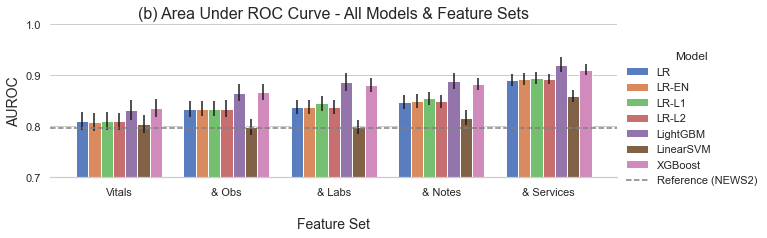

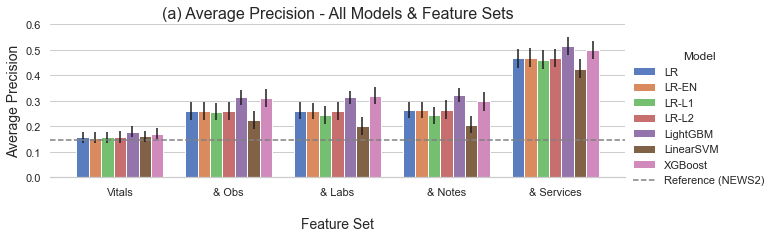

In [535]:

select_feature_ablation_barplot(METRICS, select_feature_groups, 'AUC', (0.7, 1.0), baseline=baseline_news_performance, ylabel='AUC', title='(b) Area Under ROC Curve - All Models & Feature Sets', save=f'{Notebook.IMAGE_DIR}/auc_bar_short.svg')
select_feature_ablation_barplot(METRICS, select_feature_groups, 'AP', (0.0, 0.6), baseline=baseline_news_performance, ylabel='Average Precision', title='(a) Average Precision - All Models & Feature Sets', save=f'{Notebook.IMAGE_DIR}/ap_bar_short.svg')

### Precision-Recall

In [268]:
test_set_n_days = (
    sci.loc[sci_test.index].AdmissionDateTime.max()
    - sci.loc[sci_test.index].AdmissionDateTime.min()
).days

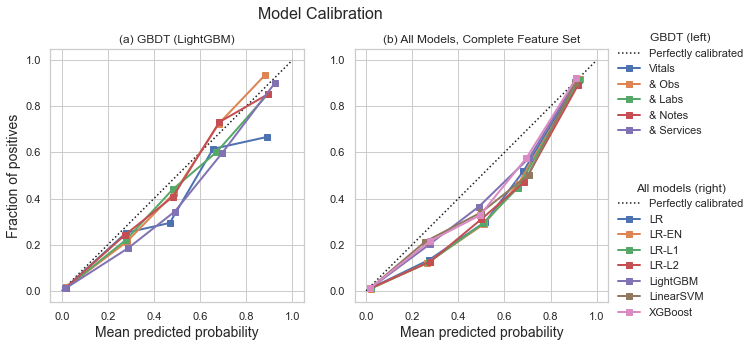

In [542]:
def model_preds_across_features(metrics, y_preds, estimator='LightGBM'):
    metrics_l = metrics[(metrics.estimator == estimator) & (metrics.features.isin(select_feature_groups.keys())) & (metrics.resampler == 'None') & (metrics.outcome_within == 1)]
    y_preds_l = y_preds[metrics_l.name]
    y_preds_l.columns=metrics_l.features.replace(select_feature_groups)
    y_preds_l = y_preds_l.to_dict(orient='list')

    return y_preds_l

def all_model_preds(metrics, y_preds, features='with_notes_labs_and_hospital'):
    metrics_r = metrics.loc[
        metrics[(metrics.features==features) & (metrics.outcome_within==1)].groupby('estimator').AP.idxmax()
    ]

    y_preds_r = y_preds[metrics_r.name]
    y_preds_r.columns=metrics_r.estimator
    y_preds_r.columns = y_preds_r.columns.map(pretty_print_models)
    y_preds_r = y_preds_r[sorted(y_preds_r.columns)]
    y_preds_r = y_preds_r.to_dict(orient='list')

    return y_preds_r

def calib_curves(metrics, y_preds, save=None):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.set_style("whitegrid")
    for _ in ax:
        _.set_box_aspect(1)
    
    y_test = sci_test.derive_critical_event(within=1, return_series=True).loc[y_preds.index]
    y_preds_l, y_preds_r = model_preds_across_features(metrics, y_preds, 'LightGBM'), all_model_preds(metrics, y_preds)

    plot_calibration_curves(y_test, y_preds_l, ax=ax[0], title='(a) GBDT (LightGBM)')
    plot_calibration_curves(y_test, y_preds_r, ax=ax[1], title='(b) All Models, Complete Feature Set')

    sns.move_legend(ax[0], "upper left", bbox_to_anchor=(2.2, 1.1), frameon=False, title='GBDT (left)')
    sns.move_legend(ax[1], "lower left", bbox_to_anchor=(1, -0.1), frameon=False, title='All models (right)')
    ax[1].set_ylabel(None)
   # fig.tight_layout(h_pad=0.5, w_pad=0.5)
    fig.subplots_adjust(top=0.9)
    fig.suptitle('Model Calibration')
    if save:
        plt.savefig(save, bbox_inches='tight', format='svg')
   

calib_curves(METRICS, Y_PREDS, save=f'{Notebook.IMAGE_DIR}/calib_curves.svg')

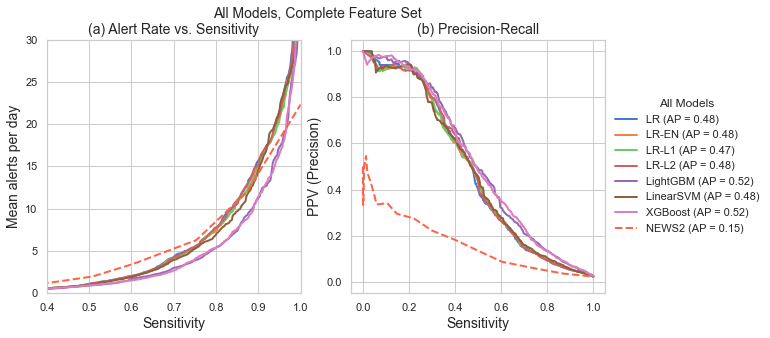

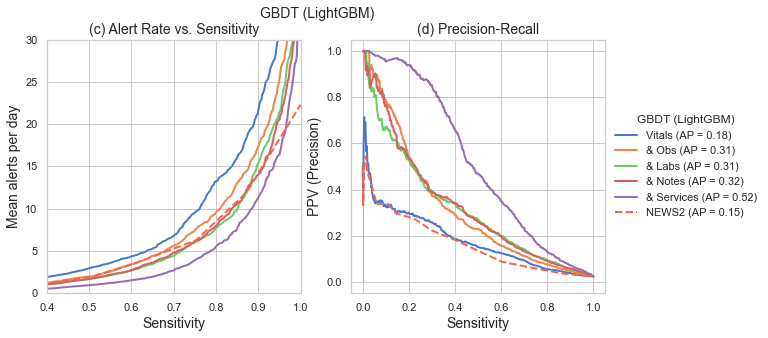

In [270]:
def pr_alert_curves(metrics, y_preds, data_function=model_preds_across_features, title='GBDT (LightGBM)', legend='GBDT (LightGBM)', save=None, debug=False, subtitles=['Alert Rate vs. Sensitivity', 'Precision-Recall']):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.set_style("whitegrid")
    for _ in ax:
        _.set_box_aspect(1)
    
    if debug:
        y_preds = y_preds.sample(1000)

    y_preds_l = data_function(metrics, y_preds)
    y_test = sci_test.derive_critical_event(within=1, return_series=True).loc[y_preds.index]
    baseline_news = {'NEWS2': sci_test.loc[y_test.index, 'NEWS_score']}
    
    with sns.color_palette('muted'):
        plot_pr_curves(y_test, y_preds_l | baseline_news, smoothing=(not debug), ax=ax[1], palette=sns.color_palette('muted'), baseline_key='NEWS2', title=subtitles[1])
        plot_alert_rate(y_test, y_preds_l | baseline_news, test_set_n_days, ax=ax[0], intercepts=False, baseline_key='NEWS2', title=subtitles[0], xlim=(0.4, 1.0), ylim=(0, 30))

        
    sns.move_legend(ax[1], "center left", bbox_to_anchor=(1, 0.5), frameon=False, title=legend)
    ax[0].legend([], [], frameon=False)
    
    fig.subplots_adjust(top=0.95)
    fig.suptitle(title, fontsize=14)
    if save:
        plt.savefig(save, bbox_inches='tight', format='svg')

pr_alert_curves(
    METRICS, Y_PREDS, all_model_preds, 
    title='All Models, Complete Feature Set', legend='All Models', 
    subtitles=['(a) Alert Rate vs. Sensitivity', '(b) Precision-Recall'],
    save=f'{Notebook.IMAGE_DIR}/alert_pr_all.svg'
)
pr_alert_curves(
    METRICS, Y_PREDS, model_preds_across_features, 
    title='GBDT (LightGBM)', legend='GBDT (LightGBM)', 
    subtitles=['(c) Alert Rate vs. Sensitivity', '(d) Precision-Recall'],
    save=f'{Notebook.IMAGE_DIR}/alert_pr_lightgbm.svg'
)

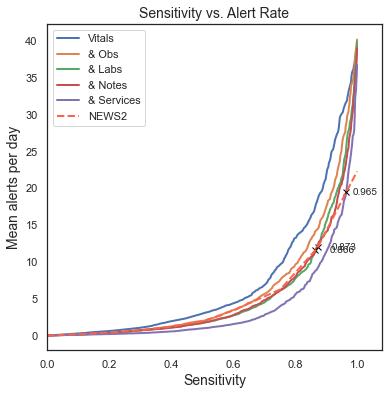

In [445]:
y_test = sci_test.derive_critical_event(within=1, return_series=True).loc[Y_PREDS.index]
baseline_news = {'NEWS2': sci_test.loc[y_test.index, 'NEWS_score']}
plot_alert_rate(y_test, model_preds_across_features(METRICS, Y_PREDS) | baseline_news, test_set_n_days, intercepts=True, baseline_key='NEWS2')

In [271]:
y_test = sci_test.derive_critical_event(within=1, return_series=True).loc[Y_PREDS.index]
baseline_news = {'NEWS2': sci_test.loc[y_test.index, 'NEWS_score']}
sensitivity, news_rate, lgbm_rate = biggest_alert_rate_diff(
    sci_test.derive_critical_event(return_series=True, within=1),
    baseline_news['NEWS2'],
    Y_PREDS["LightGBM_None_Within-1_with_notes_labs_and_hospital"],
    test_set_n_days,
)
print(
    f"At sensitivity ~{sensitivity:.3f}: NEWS Alert rate: {news_rate:.3f}, LGBM Alert rate: {lgbm_rate:.3f} -> {100-(lgbm_rate*100/news_rate):.3f}% less"
)

At sensitivity ~0.872: NEWS Alert rate: 11.915, LGBM Alert rate: 9.198 -> 22.802% less


## Comparison with NEWS

In [529]:
from sklearn.metrics import (
    precision_score,
    recall_score,
    accuracy_score,
    fbeta_score,
)

def get_threshold(y_train, y_pred_proba, target=0.85):
    """ Given prediction probabilities, sets the prediction threshold to approach the given target recall
    """

    # Get candidate thresholds from the model, and find the one that gives the best fbeta score
    precision, recall, thresholds = precision_recall_curve(y_train, y_pred_proba)
    closest = thresholds[np.abs(recall - target).argmin()]

    return closest

def news_comparison_single_score_string(score, y_true, y_pred):
    mid = score(y_true, y_pred)
    lower, upper = bootstrap_metric(score, y_true, y_pred, n_resamples=99)
    return f'{mid:.3f} ({lower:.3f}-{upper:.3f})'

def news_threshold_comparison(metrics, y_preds, models=['LightGBM', 'L2Regression'], thresholds=[3, 5, 7], confidence_intervals=True):
    nne = lambda *args, **kwargs: 1/precision_score(*args, **kwargs)
    scores = {
        'Sensitivity': recall_score,
        'Specificity': partial(recall_score, pos_label=0),
        'PPV': precision_score,
        'NPV': partial(precision_score, pos_label=0),
        'Accuracy': accuracy_score,
        'F2': partial(fbeta_score, beta=2),
        'NNE': nne
    }

    if confidence_intervals:
        compute_scores = lambda y_t, y_p: {
            score_name: news_comparison_single_score_string(score, y_t, y_p)
            for score_name, score in scores.items()
        }
    else:
        compute_scores = lambda y_t, y_p: {
            score_name: score(y_t, y_p)
            for score_name, score in scores.items()
        }

    y_true = sci_test.CriticalEvent
    news_sensitivities = {
        threshold: recall_score(y_true, sci_test.NEWS_score >= threshold) 
        for threshold in thresholds
    }

    results = [
        dict(
            Model="NEWS",
            Features=None,
            Threshold=f'$\geq {threshold}$',
          #  NEWS_Threshold=threshold
        ) | compute_scores(y_true, sci_test.NEWS_score >= threshold) for threshold, sensitivity in news_sensitivities.items()
    ]

    for model in models:
        for feature_group in select_feature_groups.keys():
            y_pred_proba = y_preds[f'{model}_None_Within-1_{feature_group}']
            for news_threshold, sensitivity in news_sensitivities.items():
                threshold = get_threshold(y_true, y_pred_proba, target=sensitivity)
                y_pred = np.where(y_pred_proba > threshold, 1, 0)
                results.append(dict(
                    Model=pretty_print_models[model],
                    Features=select_feature_groups[feature_group],
                    Threshold=f'$\geq {threshold:.3f}$',
                    #NEWS_Threshold=news_threshold
                )| compute_scores(y_true, y_pred))

    return pd.DataFrame(results).set_index(['Model', 'Features'])#[list(r.columns[-1:]) + list(r.columns[:-1])]

r = news_threshold_comparison(METRICS, Y_PREDS, confidence_intervals=False)
r

Threshold  Sensitivity  Specificity       PPV  \
Model    Features                                                       
NEWS     NaN             $\geq 3$     0.604383     0.854283  0.086426   
         NaN             $\geq 5$     0.400231     0.958855  0.181580   
         NaN             $\geq 7$     0.221453     0.986662  0.274678   
LightGBM Vitals      $\geq 0.061$     0.604383     0.901505  0.122774   
         Vitals      $\geq 0.125$     0.400231     0.959592  0.184280   
         Vitals      $\geq 0.241$     0.221453     0.987399  0.286140   
         & Obs       $\geq 0.073$     0.604383     0.924997  0.155259   
         & Obs       $\geq 0.173$     0.400231     0.977454  0.288206   
         & Obs       $\geq 0.365$     0.221453     0.994949  0.500000   
         & Labs      $\geq 0.109$     0.604383     0.943676  0.196623   
         & Labs      $\geq 0.231$     0.400231     0.981900  0.335266   
         & Labs      $\geq 0.389$     0.221453     0.994791  0.492308   
         & Notes     $\geq 0.087$     0.604383     0.942334  0.192931   
         & Notes     $\geq 0.210$     0.399077     0.982216  0.338552   
         & Notes     $\geq 0.369$     0.221453     0.995054  0.505263   
         & Services  $\geq 0.170$     0.603230     0.973956  0.345671   
         & Services  $\geq 0.430$     0.399077     0.995265  0.657795   
         & Services  $\geq 0.827$     0.222607     0.999553  0.919048   
LR-L2    Vitals      $\geq 0.054$     0.604383     0.888851  0.110339   
         Vitals      $\geq 0.105$     0.394464     0.950726  0.154402   
         Vitals      $\geq 0.210$     0.213379     0.985215  0.247657   
         & Obs       $\geq 0.038$     0.604383     0.890298  0.111632   
         & Obs       $\geq 0.146$     0.399077     0.965774  0.210079   
         & Obs       $\geq 0.348$     0.217993     0.994554  0.477273   
         & Labs      $\geq 0.050$     0.604383     0.899690  0.120821   
         & Labs      $\geq 0.153$     0.391003     0.969694  0.227364   
         & Labs      $\geq 0.364$     0.220300     0.994344  0.470443   
         & Notes     $\geq 0.057$     0.604383     0.903609  0.125119   
         & Notes     $\geq 0.156$     0.400231     0.969773  0.231952   
         & Notes     $\geq 0.359$     0.221453     0.994133  0.462651   
         & Services  $\geq 0.132$     0.605536     0.958960  0.251799   
         & Services  $\geq 0.474$     0.402537     0.994397  0.620996   
         & Services  $\geq 0.825$     0.220300     0.999132  0.852679   

                          NPV  Accuracy        F2        NNE  
Model    Features                                             
NEWS     NaN         0.989548  0.848710  0.274892  11.570611  
         NaN         0.985934  0.946398  0.322551   5.507205  
         NaN         0.982321  0.969598  0.230382   3.640625  
LightGBM Vitals      0.990090  0.894879  0.338676   8.145038  
         Vitals      0.985944  0.947118  0.324238   5.426513  
         Vitals      0.982334  0.970318  0.231940   3.494792  
         & Obs       0.990339  0.917848  0.382873   6.440840  
         & Obs       0.986198  0.964582  0.371361   3.469741  
         & Obs       0.982465  0.977700  0.249221   2.000000  
         & Labs      0.990529  0.936109  0.427197   5.085878  
         & Labs      0.986259  0.968929  0.385299   2.982709  
         & Labs      0.982463  0.977546  0.248834   2.031250  
         & Notes     0.990515  0.934798  0.423674   5.183206  
         & Notes     0.986238  0.969212  0.385301   2.953757  
         & Notes     0.982467  0.977803  0.249480   1.979167  
         & Services  0.990794  0.965688  0.524995   2.892925  
         & Services  0.986416  0.981970  0.433150   1.520231  
         & Services  0.982570  0.982227  0.262371   1.088083  
LR-L2    Vitals      0.989950  0.882507  0.318851   9.062977  
         Vitals      0.985681  0.938321  0.300897   6.476608  
         Vitals      0.982115  0.968003  0.219454   4.037838  
         & Obs     

In [530]:
r_really_big = r.reset_index().set_index(['Features', 'Model', 'Threshold']).loc[[np.nan] + list(select_feature_groups.values())]
r_really_big

Sensitivity  Specificity       PPV  \
Features   Model    Threshold                                          
NaN        NEWS     $\geq 3$         0.604383     0.854283  0.086426   
                    $\geq 5$         0.400231     0.958855  0.181580   
                    $\geq 7$         0.221453     0.986662  0.274678   
Vitals     LightGBM $\geq 0.061$     0.604383     0.901505  0.122774   
                    $\geq 0.125$     0.400231     0.959592  0.184280   
                    $\geq 0.241$     0.221453     0.987399  0.286140   
           LR-L2    $\geq 0.054$     0.604383     0.888851  0.110339   
                    $\geq 0.105$     0.394464     0.950726  0.154402   
                    $\geq 0.210$     0.213379     0.985215  0.247657   
& Obs      LightGBM $\geq 0.073$     0.604383     0.924997  0.155259   
                    $\geq 0.173$     0.400231     0.977454  0.288206   
                    $\geq 0.365$     0.221453     0.994949  0.500000   
           LR-L2    $\geq 0.038$     0.604383     0.890298  0.111632   
                    $\geq 0.146$     0.399077     0.965774  0.210079   
                    $\geq 0.348$     0.217993     0.994554  0.477273   
& Labs     LightGBM $\geq 0.109$     0.604383     0.943676  0.196623   
                    $\geq 0.231$     0.400231     0.981900  0.335266   
                    $\geq 0.389$     0.221453     0.994791  0.492308   
           LR-L2    $\geq 0.050$     0.604383     0.899690  0.120821   
                    $\geq 0.153$     0.391003     0.969694  0.227364   
                    $\geq 0.364$     0.220300     0.994344  0.470443   
& Notes    LightGBM $\geq 0.087$     0.604383     0.942334  0.192931   
                    $\geq 0.210$     0.399077     0.982216  0.338552   
                    $\geq 0.369$     0.221453     0.995054  0.505263   
           LR-L2    $\geq 0.057$     0.604383     0.903609  0.125119   
                    $\geq 0.156$     0.400231     0.969773  0.231952   
                    $\geq 0.359$     0.221453     0.994133  0.462651   
& Services LightGBM $\geq 0.170$     0.603230     0.973956  0.345671   
                    $\geq 0.430$     0.399077     0.995265  0.657795   
                    $\geq 0.827$     0.222607     0.999553  0.919048   
           LR-L2    $\geq 0.132$     0.605536     0.958960  0.251799   
                    $\geq 0.474$     0.402537     0.994397  0.620996   
                    $\geq 0.825$     0.220300     0.999132  0.852679   

                                       NPV  Accuracy        F2        NNE  
Features   Model    Threshold                                              
NaN        NEWS     $\geq 3$      0.989548  0.848710  0.274892  11.570611  
                    $\geq 5$      0.985934  0.946398  0.322551   5.507205  
                    $\geq 7$      0.982321  0.969598  0.230382   3.640625  
Vitals     LightGBM $\geq 0.061$  0.990090  0.894879  0.338676   8.145038  
                    $\geq 0.125$  0.985944  0.947118  0.324238   5.426513  
                    $\geq 0.241$  0.982334  0.970318  0.231940   3.494792  
           LR-L2    $\geq 0.054$  0.989950  0.882507  0.318851   9.062977  
                    $\geq 0.105$  0.985681  0.938321  0.300897   6.476608  
                    $\geq 0.210$  0.982115  0.968003  0.219454   4.037838  
& Obs      LightGBM $\geq 0.073$  0.990339  0.917848  0.382873   6.440840  
                    $\geq 0.173$  0.986198  0.964582  0.371361   3.469741  
                    $\geq 0.365$  0.982465  0.977700  0.249221   2.000000  
           LR-L2    $\geq 0.038$  0.989966  0.883922  0.321000   8.958015  
                    $\geq 0.146$  0.986007  0.953137  0.338221   4.760116  
                    $\geq 0.348$  0.982382  0.977237  0.244565   2.095238  
& Labs     LightGBM $\geq 0.109$  0.990529  0.936109  0.427197   5.085878  
                    $\geq 0.231$  0.986259  0.968929  0.385299   2.982709  
                    $\geq 0.389$  0.982463  0.977546  0.248834   2.03

In [531]:
print(r_really_big.to_latex(multirow=True, escape=False, formatters=[lambda _: f'${_:.4f}$'] * r_really_big.shape[1]))

\begin{tabular}{lllrrrrrrr}
\toprule
           &       &              & Sensitivity & Specificity &      PPV &      NPV & Accuracy &       F2 &       NNE \\
Features & Model & Threshold &             &             &          &          &          &          &           \\
\midrule
\multirow{3}{*}{NaN} & \multirow{3}{*}{NEWS} & $\geq 3$ &    $0.6044$ &    $0.8543$ & $0.0864$ & $0.9895$ & $0.8487$ & $0.2749$ & $11.5706$ \\
           &       & $\geq 5$ &    $0.4002$ &    $0.9589$ & $0.1816$ & $0.9859$ & $0.9464$ & $0.3226$ &  $5.5072$ \\
           &       & $\geq 7$ &    $0.2215$ &    $0.9867$ & $0.2747$ & $0.9823$ & $0.9696$ & $0.2304$ &  $3.6406$ \\
\cline{1-10}
\cline{2-10}
\multirow{6}{*}{Vitals} & \multirow{3}{*}{LightGBM} & $\geq 0.061$ &    $0.6044$ &    $0.9015$ & $0.1228$ & $0.9901$ & $0.8949$ & $0.3387$ &  $8.1450$ \\
           &       & $\geq 0.125$ &    $0.4002$ &    $0.9596$ & $0.1843$ & $0.9859$ & $0.9471$ & $0.3242$ &  $5.4265$ \\
           &       & $\geq 0.241$ &    

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


In [508]:
r_restricted = r[r.index.isin([('NEWS', np.nan), ('LightGBM', '& Services'), ('LR-L2', '& Services')])]
r_restricted = r_restricted.droplevel(1).reset_index().set_index(['Model', 'Threshold'])
r_restricted

Sens      Spec       PPV       NPV  Accuracy  \
Model    Threshold                                                        
NEWS     $\geq 3$      0.604383  0.854283  0.086426  0.989548  0.848710   
         $\geq 5$      0.400231  0.958855  0.181580  0.985934  0.946398   
         $\geq 7$      0.221453  0.986662  0.274678  0.982321  0.969598   
LightGBM $\geq 0.170$  0.603230  0.973956  0.345671  0.990794  0.965688   
         $\geq 0.430$  0.399077  0.995265  0.657795  0.986416  0.981970   
         $\geq 0.827$  0.222607  0.999553  0.919048  0.982570  0.982227   
LR-L2    $\geq 0.132$  0.605536  0.958960  0.251799  0.990705  0.951079   
         $\geq 0.474$  0.402537  0.994397  0.620996  0.986481  0.981198   
         $\geq 0.825$  0.220300  0.999132  0.852679  0.982512  0.981764   

                             F2        NNE  
Model    Threshold                          
NEWS     $\geq 3$      0.274892  11.570611  
         $\geq 5$      0.322551   5.507205  
         $\geq 7$      0.230382   3.640625  
LightGBM $\geq 0.170$  0.524995   2.892925  
         $\geq 0.430$  0.433150   1.520231  
         $\geq 0.827$  0.262371   1.088083  
LR-L2    $\geq 0.132$  0.472717   3.971429  
         $\geq 0.474$  0.433002   1.610315  
         $\geq 0.825$  0.258667   1.172775

In [507]:
print(r_restricted.to_latex(bold_rows=False, multirow=True, escape=False, column_format='lll|rrrrrr', formatters=[lambda _:f'${_:.3f}$'] * r_restricted.shape[1]))

\begin{tabular}{lll|rrrrrr}
\toprule
      &              &    Sens &    Spec &     PPV &     NPV & Accuracy &      F2 &      NNE \\
Model & Threshold &         &         &         &         &          &         &          \\
\midrule
\multirow{3}{*}{NEWS} & $\geq 3$ & $0.604$ & $0.854$ & $0.086$ & $0.990$ &  $0.849$ & $0.275$ & $11.571$ \\
      & $\geq 5$ & $0.400$ & $0.959$ & $0.182$ & $0.986$ &  $0.946$ & $0.323$ &  $5.507$ \\
      & $\geq 7$ & $0.221$ & $0.987$ & $0.275$ & $0.982$ &  $0.970$ & $0.230$ &  $3.641$ \\
\cline{1-9}
\multirow{3}{*}{LightGBM} & $\geq 0.170$ & $0.603$ & $0.974$ & $0.346$ & $0.991$ &  $0.966$ & $0.525$ &  $2.893$ \\
      & $\geq 0.430$ & $0.399$ & $0.995$ & $0.658$ & $0.986$ &  $0.982$ & $0.433$ &  $1.520$ \\
      & $\geq 0.827$ & $0.223$ & $1.000$ & $0.919$ & $0.983$ &  $0.982$ & $0.262$ &  $1.088$ \\
\cline{1-9}
\multirow{3}{*}{LR-L2} & $\geq 0.132$ & $0.606$ & $0.959$ & $0.252$ & $0.991$ &  $0.951$ & $0.473$ &  $3.971$ \\
      & $\geq 0.474$ & $0.40

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


PPV       NPV  \
Model        Features                     NEWS_Threshold                       
NEWS         NaN                          3               0.086426  0.989548   
                                          5               0.181580  0.985934   
                                          7               0.274678  0.982321   
LightGBM     news                         3               0.122774  0.990090   
                                          5               0.184280  0.985944   
                                          7               0.286140  0.982334   
             news_with_phenotype          3               0.155259  0.990339   
                                          5               0.288206  0.986198   
                                          7               0.500000  0.982465   
             with_labs                    3               0.196623  0.990529   
                                          5               0.335266  0.986259   
                                          7               0.492308  0.982463   
             with_notes_and_labs          3               0.192931  0.990515   
                                          5               0.338552  0.986238   
                                          7               0.505263  0.982467   
             with_notes_labs_and_hospital 3               0.345671  0.990794   
                                          5               0.657795  0.986416   
                                          7               0.919048  0.982570   
L2Regression news                         3               0.110339  0.989950   
                                          5               0.154402  0.985681   
                                          7               0.247657  0.982115   
             news_with_phenotype          3               0.111632  0.989966   
                                          5               0.210079  0.986007   
                                          7               0.477273  0.982382   
             with_labs                    3               0.120821  0.990070   
                                          5               0.227364  0.985878   
                                          7               0.470443  0.982429   
             with_notes_and_labs          3               0.125119  0.990113   
                                          5               0.231952  0.986090   
                                          7               0.462651  0.982451   
             with_notes_labs_and_hospital 3               0.251799  0.990705   
                                          5               0.620996  0.986481   
                                          7               0.852679  0.982512   

                                                              Sens      Spec  \
Model        Features                     NEWS_Threshold                       
NEWS         NaN                          3               0.604383  0.854283   
                                          5               0.400231  0.958855   
                                          7               0.221453  0.986662   
LightGBM     news                         3               0.604383  0.901505   
                                          5               0.400231  0.959592   
                                          7               0.221453  0.987399   
             news_with_phenotype          3               0.604383  0.924997   
                                          5               0.400231  0.977454   
                                          7               0.221453  0.994949   
             with_labs                    3               0.604383  0.943676   
                                          5               0.400231  0.981900   
                                          7               0.221453  0.994791   
             with_notes_and_labs          3               0.604383  0.942334   
                                          5               0.39

## Sub-scores

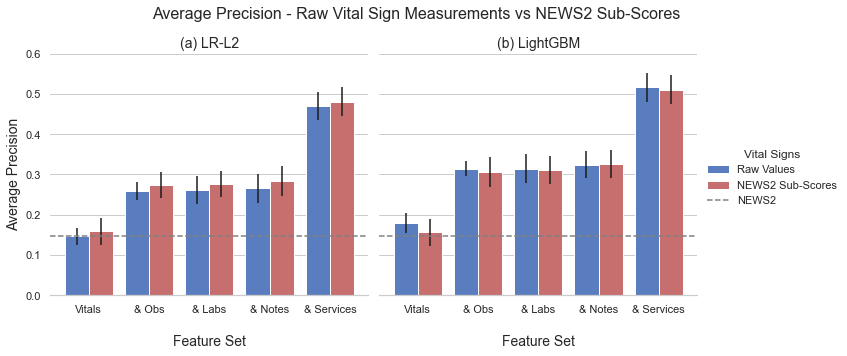

In [428]:
def subscores_barplot(metrics, feature_groups, scored_feature_groups, metric='AP', ylim=(0.0, 0.6), baseline=None, save=None):
    df = metrics[(metrics.estimator.isin(['LightGBM', 'L2Regression'])) & (metrics.resampler=='None')].copy()
    
    df['Vital Signs'] = df['features'].isin(scored_feature_groups.keys()).map({
        True:'NEWS2 Sub-Scores',
        False:'Raw Values'
    })
    df.loc[(df.estimator == 'L2Regression')&(df.features=='news'), metric] -= 0.010
    df.loc[(df.estimator == 'LightGBM')&(df.features.isin(scored_feature_groups.keys()))&~(df.features.isin(['news_scores', 'scores_with_notes_labs_and_hospital'])), metric] -= 0.01
    df['features'] = df.features.map(feature_groups | scored_feature_groups)
    err = (df[f'{metric}_Upper']-df[f'{metric}_Lower'])/2
    df = df.rename(columns=dict(
        features='Features',
        estimator='Model',
    ))
    df['Model'] = df.Model.replace(dict(
        L2Regression='(a) LR-L2',
        LightGBM = '(b) LightGBM'
    ))

    sns.set_style('whitegrid')

    g = sns.catplot(
        data=df, x='Features', y=metric, hue='Vital Signs', col='Model',
        kind='bar', palette=[sns.color_palette('muted')[0], sns.color_palette('muted')[3]], height=6, orient='v', legend=False, 
    )
    g.despine(left=True)
    g.fig.set_size_inches(10,5)
    subp = [(i, model, ax) for i, (model, ax) in enumerate(g.axes_dict.items())]
    for i, model, ax in subp:
        ax.set_ylim(ylim)
        x_coords = [p.get_x() + 0.5*p.get_width() for p in ax.patches]
        y_coords = [p.get_height() for p in ax.patches]
        ax.errorbar(x=x_coords, y=y_coords, yerr=err[(df.Model==model)], fmt="none", c= "k")
    g.set_xlabels("Feature Set", labelpad=20, fontsize=14)
    g.set_ylabels('Average Precision', fontsize=14)
    if baseline is not None:
        g.refline(y = baseline[metric], color = 'gray', linestyle = '--', label = "NEWS2") 
        g.add_legend(title='Vital Signs')
    
    g.set_titles(template='{col_name}', size=14)
    g.fig.suptitle('Average Precision - Raw Vital Sign Measurements vs NEWS2 Sub-Scores')
    g.fig.subplots_adjust(top=0.85)

    if save:
        plt.savefig(save, bbox_inches="tight", format='svg')

subscores_barplot(METRICS, select_feature_groups, select_scored_feature_groups, baseline=baseline_news_performance, save=f'{Notebook.IMAGE_DIR}/raw_vs_scored_ap.svg')


## LR Coefficients

In [68]:
from utils.evaluation import get_calibrated_regression_coefficients, regression_coefficient_sorted_barplot
def get_coefficients(name, onehot_cols=None, directory=Notebook.SYS_RESULTS_DIR):
    if onehot_cols is None:
        X_train, X_test, y_train, y_test = get_xy(scii, Estimator_L1Regression, scii.feature_group_combinations['with_notes_labs_and_hospital'])
        onehot_cols = X_train.get_onehot_categorical_columns()
    
    model, *_ = load_model(name, directory)
    coef = get_calibrated_regression_coefficients(
        model, model.feature_names_in_, name.split('_')[0]
    ).set_index('Feature').Coefficient

    cat_cols = select_categorical_cols | dict(AdmissionMethod='Admission Pathway')

    coef_num = coef[~coef.index.isin([__ for _ in onehot_cols.values() for __ in _])].sort_values()
    coef_cat = pd.DataFrame([dict(
        Feature=cat_cols[key],
        Value=_,
        Coef=coef.loc[_]    
    ) for key, val in onehot_cols.items() for _ in val if _ in coef.index])
    coef_cat.Value = coef_cat.Value.str.split('__').str[1]

    return coef_num, coef_cat

#coef_num, coef_cat = get_coefficients('L1Regression_None_Within-1_with_notes_labs_and_hospital')

In [70]:
X_train, X_test, y_train, y_test = get_xy(scii, Estimator_L1Regression, scii.feature_group_combinations['with_notes_labs_and_hospital'])
onehot_cols = X_train.get_onehot_categorical_columns()

In [71]:
def categorical_coefficient_table(onehot_cols, estimators=['LogisticRegression', 'L1Regression', 'L2Regression', 'ElasticNetRegression'], feature_group='with_notes_labs_and_hospital', directory=Notebook.SYS_RESULTS_DIR, within=1):
    r = pd.concat((
        get_coefficients(
            f'{estimator}_None_Within-{within}_{feature_group}', onehot_cols, directory=directory
        )[1].assign(Model=pretty_print_models[estimator]).replace('NAN', 'Unknown')
    ) for estimator in estimators)
    r.Value = r.Value.replace(pretty_print_categoricals)
    top = r.copy()
    top.Coef = top.Coef.apply(abs)
    top = top.groupby(['Feature', 'Value']).mean().groupby('Feature').Coef.nlargest(5).droplevel(0).index
    return r.pivot(index=['Feature', 'Value'], columns='Model', values='Coef').loc[top].round(4)

cat_coef = categorical_coefficient_table(onehot_cols)
cat_coef

Model                                           LR   LR-EN   LR-L1   LR-L2
Feature              Value                                                
A&E Diagnosis        dementia              -5.7765 -1.1784  0.0000 -0.9183
                     dizz-                 -4.5919 -0.5101  0.0000 -0.5284
                     Unknown                1.1955  0.5185  0.4662  0.6791
                     diarrh                 0.9823  0.2567  0.0000  0.4210
                     collaps-               0.8968  0.2167  0.0000  0.3797
Admission Pathway    Emg. Tran. Oth. Prov.  1.1180  1.5083  0.8563  1.6927
                     Elective Booked       -2.8855 -1.2208  0.0000 -0.8683
                     Emg. OPD              -1.7830 -1.2437  0.0000 -0.9072
                     Booked Adm.           -1.5348 -1.0707  0.0000 -0.7858
                     Emg. A&E               0.4351  0.8734  0.9080  1.1078
Admission Specialty  General Med.           6.0295  4.4717  4.5527  4.2806
                     Respiratory Med.       5.7150  4.1316  3.7710  3.8547
                     Geriatric Med.         5.1367  3.5265  2.4572  3.1878
                     Bariatric Surg.        8.3252  2.2719  0.0000  1.7883
                     Spinal Surg. Svc.     -6.1272 -2.0428  0.0000 -1.5927
Breathing Device     NHF                    3.1081  3.1803  3.0982  3.0330
                     Unknown               -5.8139 -1.2859  0.0000 -0.6555
                     A - Air               -1.4371 -1.6811 -1.3501 -0.8618
                     NIV - NIV              1.1222  1.2162  1.2235  1.1433
                     Other                  0.8460  0.9446  1.1644  0.8756
Presenting Complaint ear problems          -6.0519 -1.5286  0.0000 -1.2409
                     facial problems       -5.5940 -1.4631  0.0000 -1.1675
                     gi bleeding            2.8015  1.7446  1.3005  1.7253
                     diabetes               2.7086  1.6517  1.1506  1.6313
                     testicular pain       -4.8856 -0.9064  0.0000 -0.8156

In [72]:
print(cat_coef.to_latex(bold_rows=True, multirow=True, column_format='llrrrr'))

\begin{tabular}{llrrrr}
\toprule
                     & \textbf{Model} &      LR &   LR-EN &   LR-L1 &   LR-L2 \\
\textbf{Feature} & \textbf{Value} &         &         &         &         \\
\midrule
\multirow{5}{*}{\textbf{A\&E Diagnosis}} & \textbf{dementia} & -5.7765 & -1.1784 &  0.0000 & -0.9183 \\
                     & \textbf{dizz-} & -4.5919 & -0.5101 &  0.0000 & -0.5284 \\
                     & \textbf{Unknown} &  1.1955 &  0.5185 &  0.4662 &  0.6791 \\
                     & \textbf{diarrh} &  0.9823 &  0.2567 &  0.0000 &  0.4210 \\
                     & \textbf{collaps-} &  0.8968 &  0.2167 &  0.0000 &  0.3797 \\
\cline{1-6}
\multirow{5}{*}{\textbf{Admission Pathway}} & \textbf{Emg. Tran. Oth. Prov.} &  1.1180 &  1.5083 &  0.8563 &  1.6927 \\
                     & \textbf{Elective Booked} & -2.8855 & -1.2208 &  0.0000 & -0.8683 \\
                     & \textbf{Emg. OPD} & -1.7830 & -1.2437 &  0.0000 & -0.9072 \\
                     & \textbf{Booked Adm.} & -1.5348 & -1.

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


In [73]:
def numerical_coefficient_table(estimators=['LogisticRegression', 'L1Regression', 'L2Regression', 'ElasticNetRegression'], feature_group='with_notes_labs_and_hospital', directory=Notebook.SYS_RESULTS_DIR, within=1):
    X_train, X_test, y_train, y_test = get_xy(scii, Estimator_L1Regression, scii.feature_group_combinations['with_notes_labs_and_hospital'])
    onehot_cols = X_train.get_onehot_categorical_columns()
    r = pd.concat((
        (
            get_coefficients(f'{_}_None_Within-{within}_{feature_group}', onehot_cols, directory=directory)[0].rename(_)
        ) for _ in estimators), axis=1
    ).round(4).T

    r.columns = map(SCICols.pretty_print_columns.get, r.columns)
    r.index = map(pretty_print_models.get, r.index)
    return r

coef = numerical_coefficient_table()
#coef.T

In [74]:
coef.T

,LR,LR-L1,LR-L2,LR-EN
Sent To SDEC,-1.0367,-1.0309,-1.0391,-1.0384
Sodium,-0.8081,-0.7383,-0.8016,-0.8073
Age,-0.5460,-0.4507,-0.5434,-0.5433
FiO2,-0.4453,-0.4357,-0.4423,-0.4440
SpO2,-0.1996,-0.1972,-0.1994,-0.1993
Creatinine,-0.1968,-0.1889,-0.1953,-0.1950
Assisted Breathing,-0.1301,-0.1242,-0.1292,-0.1288
Readmission,-0.1131,-0.0779,-0.1144,-0.1143
Temperature,-0.0525,-0.0449,-0.0517,-0.0520
Alert (AVCPU),-0.0456,-0.0183,-0.0408,-0.0413


In [75]:
print(coef.T.to_latex(bold_rows=True, column_format='lrrrr',  formatters=[lambda x: f'${x}$' for _ in range(4)], escape=False))

\begin{tabular}{lrrrr}
\toprule
{} &        LR &     LR-L1 &     LR-L2 &     LR-EN \\
\midrule
\textbf{Sent To SDEC      } & $-1.0367$ & $-1.0309$ & $-1.0391$ & $-1.0384$ \\
\textbf{Sodium            } & $-0.8081$ & $-0.7383$ & $-0.8016$ & $-0.8073$ \\
\textbf{Age               } &  $-0.546$ & $-0.4507$ & $-0.5434$ & $-0.5433$ \\
\textbf{FiO2              } & $-0.4453$ & $-0.4357$ & $-0.4423$ &  $-0.444$ \\
\textbf{SpO2              } & $-0.1996$ & $-0.1972$ & $-0.1994$ & $-0.1993$ \\
\textbf{Creatinine        } & $-0.1968$ & $-0.1889$ & $-0.1953$ &  $-0.195$ \\
\textbf{Assisted Breathing} & $-0.1301$ & $-0.1242$ & $-0.1292$ & $-0.1288$ \\
\textbf{Readmission       } & $-0.1131$ & $-0.0779$ & $-0.1144$ & $-0.1143$ \\
\textbf{Temperature       } & $-0.0525$ & $-0.0449$ & $-0.0517$ &  $-0.052$ \\
\textbf{Alert (AVCPU)     } & $-0.0456$ & $-0.0183$ & $-0.0408$ & $-0.0413$ \\
\textbf{Systolic BP       } & $-0.0205$ & $-0.0216$ & $-0.0212$ & $-0.0215$ \\
\textbf{Urea              } &  $0.00

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


## SHAP

In [273]:
from utils.evaluation import plot_shap_features_joint, plot_calibrated_regression_coefficients

In [409]:
def load_filtered_explanations(name, directory):
    _, e = load_model(name, directory)
    e = e[scii.iloc[-39950:].index.isin(sci_test.index)]

    col = 'AdmissionMethodDescription'
    col = col if col in e.feature_names else 'AdmissionMethod'
    elective_mask = pd.Series(e[:, e.feature_names.index(col)].data).isin(['BOOKED ADMISSION ', 'ELECTIVE PLANNED']).values
    age_mask = (pd.Series(e[:, e.feature_names.index('Age')].data) < 18).values

    e = e[(~age_mask) & (~elective_mask)]
    
    return e

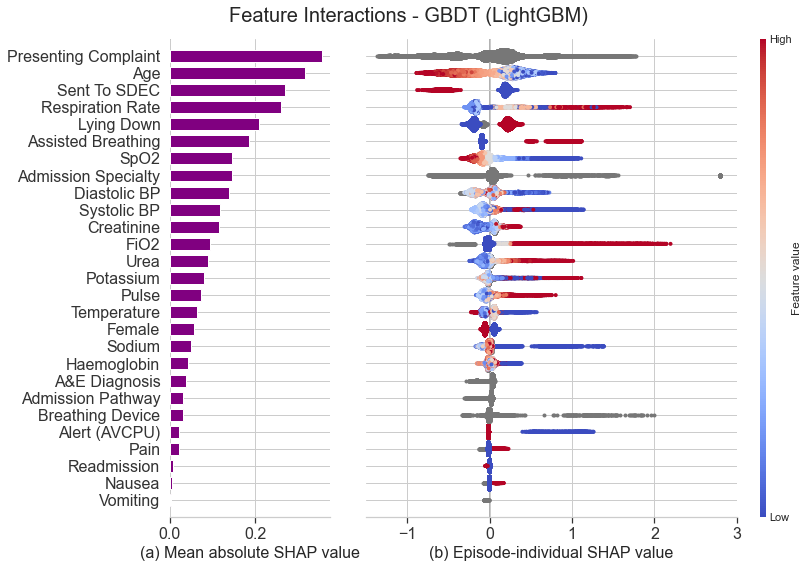

In [389]:
def lgbm_explanations(name='LightGBM_None_Within-1_with_notes_labs_and_hospital', directory=Notebook.SYS_RESULTS_DIR, save=None, title='Feature Interactions - GBDT (LightGBM)'):
    _, explanations = load_filtered_explanations(name, directory)

    explanations.feature_names = list(map(SCICols.pretty_print_columns.get, explanations.feature_names))
    explanations.values[explanations.values >= 2.8] = 2.8
    plot_shap_features_joint(
        explanations, 
        max_display=250,
        figsize=(12, 8),
        wspace=-0.25,
        bar_aspect=0.04,
        topadjust=0.925,
        title=title,
        save=save
    )
    
expl = lgbm_explanations(save=f'{Notebook.IMAGE_DIR}/shap_lgbm.png')

In [7]:
def lgbm_patient(name='LightGBM_None_Within-1_with_notes_labs_and_hospital', directory=Notebook.SYS_RESULTS_DIR, patient_number=1240630):
    explanations = load_filtered_explanations(name, directory)
    explanations.feature_names = list(map(SCICols.pretty_print_columns.get, explanations.feature_names))
    explanations.values[explanations.values >= 2.8] = 2.8
    explanation = explanations[sci_test.reset_index().index[(sci_test.PatientNumber==1240630)&(sci_test.CriticalEvent==True)&(sci_test.NEWS_score < 7)][0]]
    display(sci_test[sci_test.PatientNumber==patient_number].drop([_ for _ in sci_test.columns if _.startswith("SHMI__")], axis=1))
    shap.initjs()
    return shap.plots.force(
        explanation,
        matplotlib=False,
        contribution_threshold=0.08,
        show=False,
        text_rotation=15,
    )

lgbm_patient()

,SpellSerial,PatientNumber,SEQ,Female,Age,AgeBand,Area,AdmissionDateTime,DischargeDateTime,TotalLOS,LOSBand,Over7Days,Over14Days,AdmittedAfterAEC,AdmissionMethodDescription,AssessmentAreaAdmission,AssessmentAreaDischarge,AdmissionSpecialty,LastSpecialty,AdmitWard,NextWard2,NextWard3,NextWard4,NextWard5,NextWard6,NextWard7,NextWard8,NextWard9,DischargeWard,AdmitWardLOS,NextWard2LOS,NextWard3LOS,NextWard4LOS,NextWard5LOS,NextWard6LOS,NextWard7LOS,NextWard8LOS,NextWard9LOS,DischargeWardLOS,DiedDuringStay,DiedWithin30Days,AandEPresentingComplaint,AandEArrivalTime,AandEDepartureTime,AandEPatientGroupDescription,MainOPCS4,SecOper1,SecOper2,SecOper3,SecOper4,SecOper5,SecOper6,SpellHRG,HRGDesc,PrimarySpecialtyLocalCode,CareHome,PCT,GPPractice,Haemoglobin,Urea_serum,Sodium_serum,Potassium_serum,Creatinine,NEWS_score,NewsCreatedWhen,NewsTouchedWhen,NewsAuthoredDtm,Respiration_rate,NEWS_resp_rate_score,AssistedBreathing,BreathingDevice,NEWS_device_air_score,O2_saturation,Oxygen_flow_rate,NEWS_O2_sat_score,Temperature,NEWS_temperature_score,LyingDown,SystolicBP,DiastolicBP,NEWS_BP_score,HeartRate,NEWS_heart_rate_score,AVCPU_Alert,NEWS_level_of_con_score,Pain,Nausea,VomitingSinceLastRound,ReadmissionTimespan,ReadmissionBand,Readmission,Readmitted,ReadmittedTimespan,SentToSDEC,AandEMainDiagnosis,CriticalEvent,DiedWithinThreshold,CriticalCare
99794,773828_6,1240630,1,False,53,50 - 64,M27,2019-12-02 02:50:00,2019-12-02 14:14:00,0.475000,Less than 12 Hrs,False,False,False,EMERGENCY A+E,True,True,ACUTE INTERNAL MEDICINE,ACUTE INTERNAL MEDICINE,EAU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EAU,0.475000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.475000,False,False,NaN,2019-12-01 17:55:00,2019-12-02 02:50:00,medical,M47.9,NaN,NaN,NaN,NaN,NaN,NaN,LB15E,"Minor Bladder Procedures, 19 years and over",AIM,False,01G,P87019,121.0,3.5,143.0,4.1,87.0,3.0,2019-12-04 00:01:06,2019-12-04 00:01:06,2019-12-03 23:00:00,16.0,0.0,False,A - Air,0.0,96.0,0.000,0.0,36.8,0.0,True,132.0,78.0,0.0,79.0,0.0,False,3.0,0.0,False,False,NaT,N/A,False,True,1 days 18:20:00,False,NaN,False,False,False
55599,773828_8,1240630,2,False,53,50 - 64,M27,2019-12-03 21:10:00,2019-12-04 12:00:00,0.618055,12 - 24 Hrs,False,False,False,EMERGENCY A+E,False,False,GENERAL MEDICINE,ACUTE INTERNAL MEDICINE,HH1M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HH1M,0.618055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.618055,False,False,overdose and poisoning,2019-12-03 15:38:00,2019-12-03 21:10:00,medical,X29.2,NaN,NaN,NaN,NaN,NaN,NaN,WH04E,"Poisoning Diagnosis without Interventions, wit...",MED,False,01G,P87019,121.0,3.5,143.0,4.1,87.0,2.0,2019-12-04 05:54:23,2019-12-04 05:54:23,2019-12-04 01:30:00,21.0,2.0,False,A - Air,0.0,96.0,0.000,0.0,36.9,0.0,True,132.0,70.0,0.0,82.0,0.0,True,0.0,0.0,False,False,1 days 18:20:00,1 Week,True,True,11 days 03:12:00,False,NaN,True,False,True
43464,773828_10,1240630,3,False,53,50 - 64,M27,2019-12-15 00:22:00,2019-12-16 17:22:00,1.708333,36 - 48 Hrs,False,False,False,EMERGENCY A+E,True,True,ACUTE INTERNAL MEDICINE,ACUTE INTERNAL MEDICINE,EAU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EAU,1.708333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.708333,False,False,sepsis,2019-12-14 14:37:00,2019-12-14 23:59:00,medical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WH04D,"Poisoning Diagnosis without Interventions, wit...",AIM,False,01G,P87019,120.0,4.3,140.0,4.0,84.0,4.0,2019-12-16 11:20:29,2019-12-16 11:20:29,2019-12-16 11:19:00,16.0,0.0,True,N - Nasal cannula,2.0,94.0,0.162,1.0,36.5,0.0,False,112.0,80.0,0.0,98.0,1.0,True,0.0,0.0,False,False,11 days 03:12:00,1 Month,True,True,2 days 21:02:00,False,NaN,False,False,False
36096,773828_12,1240630,4,False,53,50 - 64,M27,2019-12-17 21:24:00,2019-12-20 09:20:00,2.497222,48 - 72 Hrs,False,False,False,EMERGENCY A+E,False,False,GENERAL MEDICINE,ACUTE INTERNAL MEDICINE,HH1M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M2,1.075694,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.421528,False,False,overdose and poisoning,2019-12-17 16:07:00,2019-12-17 21:24:00,medical,X29.2,NaN,NaN,NaN,NaN,NaN,NaN,WH04D,"Poisoning Diagnosis without Interventio

The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


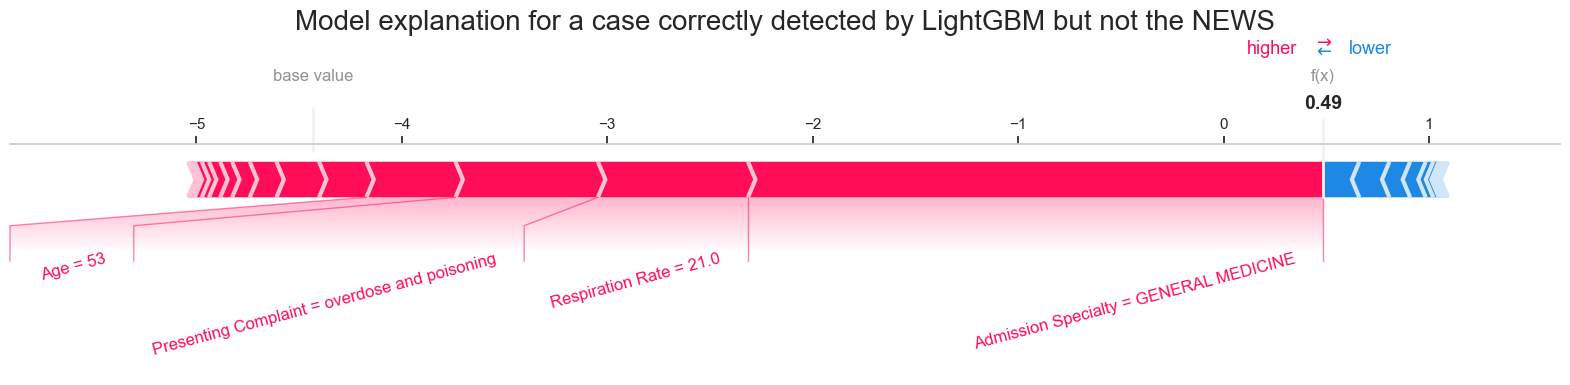

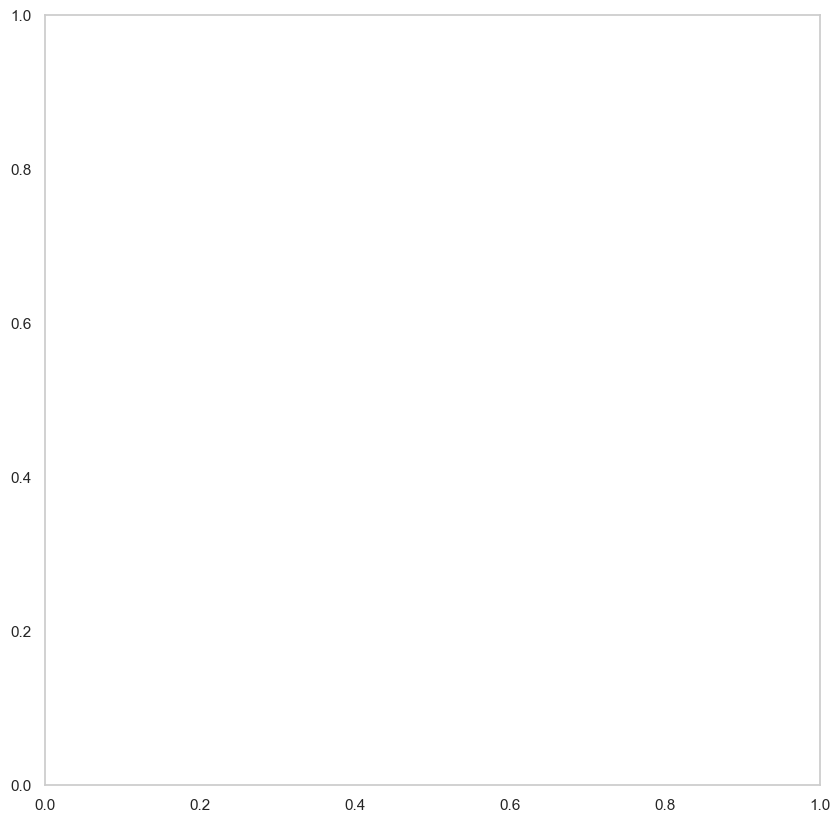

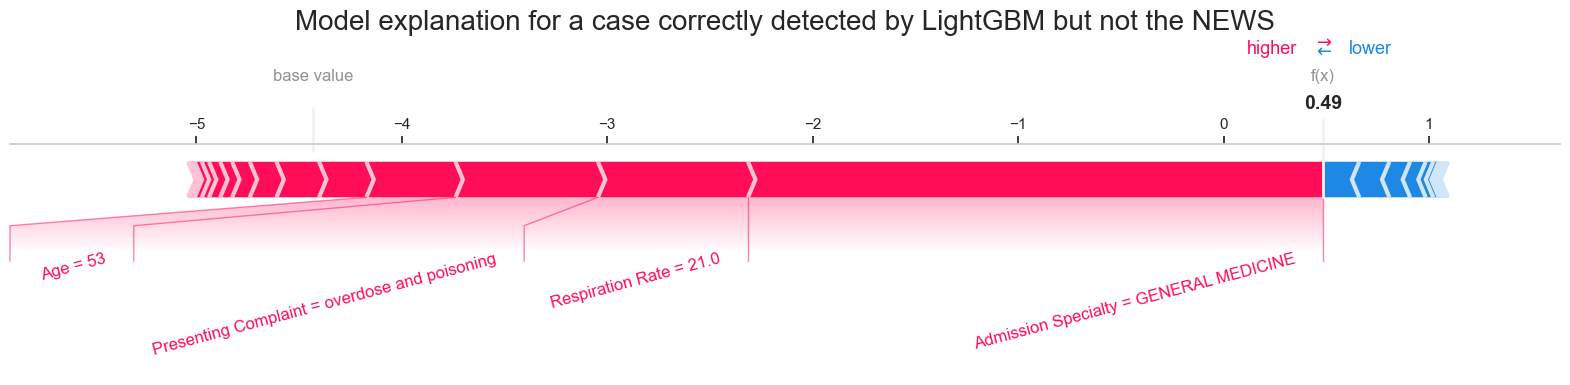

In [47]:
def lgbm_patient(name='LightGBM_None_Within-1_with_notes_labs_and_hospital', directory=Notebook.SYS_RESULTS_DIR, patient_number=1240630):
    explanations = load_filtered_explanations(name, directory)
    
    explanations.feature_names = list(map(SCICols.pretty_print_columns.get, explanations.feature_names))
    explanations.values[explanations.values >= 2.8] = 2.8
    explanation = explanations[sci_test.reset_index().index[(sci_test.PatientNumber==1240630)&(sci_test.CriticalEvent==True)&(sci_test.NEWS_score < 7)][0]]
    plt.grid(b=None)
    fig = shap.plots.force(
        explanation,
        matplotlib=True,
        contribution_threshold=0.08,
        show=False,
        text_rotation=15,
    )
    plt.grid(visible=False)
    plt.title('Model explanation for a case correctly detected by LightGBM but not the NEWS', y=1.46, fontsize=20)
    plt.savefig(
       f"lgbm_force_plot.png",
       bbox_inches="tight",
    )
    return fig
    

lgbm_patient()

In [56]:
def categorical_shap_table_lgbm():
    explanations = load_filtered_explanations('LightGBM_None_Within-1_with_notes_labs_and_hospital', Notebook.SYS_RESULTS_DIR)

    explanations.values[explanations.values > 3] = 3
    common = [_ for _ in explanations.feature_names if _ in select_categorical_cols.keys()]
    r = []
    for feature in common:
        idx = explanations.feature_names.index(feature)
        df = pd.DataFrame(
            zip(explanations[:, idx].values, explanations[:, idx].data), 
            columns=['Value', 'Data']).pivot(columns='Data').Value
        selected = df.apply(abs).mean().sort_values().tail(6).index
        r.append(df.mean().loc[selected].sort_values().rename(select_categorical_cols[feature]))
    return pd.concat([_.reset_index() for _ in r], axis=1)

categorical_shap_table_lgbm()

,Data,Breathing Device,Data,Presenting Complaint,Data,A&E Diagnosis,Data,Admission Pathway,Data,Admission Specialty
0,TM - Tracheostomy mask,0.887815,back pain,-1.147341,pain,-0.192698,EMERGENCY GP REFER,-0.210166,ACCIDENT & EMERGENCY,-0.488351
1,H40 - Humidified 40%,1.001827,facial problems,-0.954896,head,-0.165551,BOOKED ADMISSION,-0.170261,SPINAL SURGERY SERVICE,-0.425992
2,Other,1.169430,major trauma,0.936363,cope,-0.091810,EMERGENCY OPD,-0.162680,NEUROSURGERY,0.835063
3,CPAP - CPAP,1.212415,asthma,1.014811,diarrh,-0.078984,NON EM TRAN OTH PROV,-0.101525,GENERAL SURGERY,0.853884
4,NIV - NIV,1.424409,diabetes,1.456625,vomit,-0.021842,ELECTIVE PLANNED,-0.093545,UROLOGY,1.095803
5,NHF,1.636768,gi bleeding,1.484948,NaN,0.034924,EMERG TRAN OTH PROV,-0.054238,STROKE NEUROLOGY,1.368388


In [396]:
def categorical_shap_bars_lgbm():
    explanations = load_filtered_explanations('LightGBM_None_Within-1_with_notes_labs_and_hospital', Notebook.SYS_RESULTS_DIR)
    explanations.values[explanations.values > 3] = 3

    common = [_ for _ in explanations.feature_names if _ in select_categorical_cols.keys()]
    r = []
    for feature in common:
        idx = explanations.feature_names.index(feature)
        df = pd.DataFrame(
            zip(explanations[:, idx].values, explanations[:, idx].data), 
            columns=['Value', 'Data']).pivot(columns='Data').Value
        selected = df.apply(abs).mean().sort_values().tail(10).index
        r.append(df.mean().loc[selected].sort_values().rename('SHAP').to_frame().assign(Feature=select_categorical_cols[feature]))

    return pd.concat(r).reset_index()

df = categorical_shap_bars_lgbm()
df['Data'] = df['Data'].replace(pretty_print_categoricals)
df['Feature'] = df['Feature'].replace({'A&E Diagnosis': 'ED Diagnosis'})

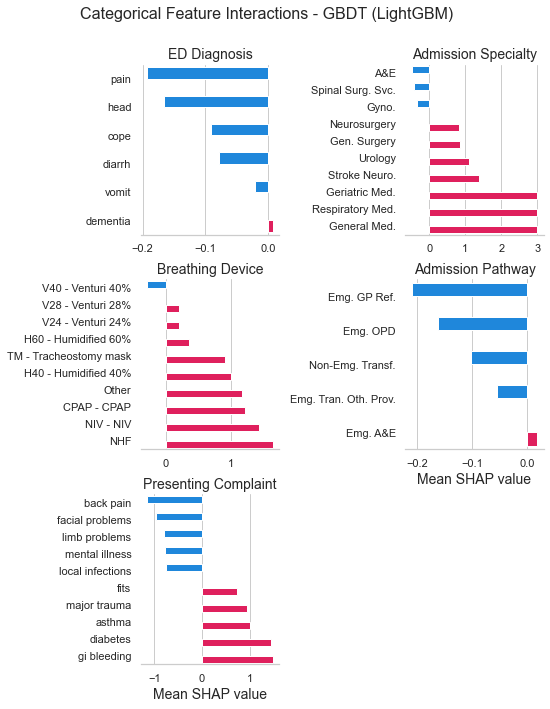

In [398]:
df['Hue'] = (df.SHAP > 0).astype(int)
sns.set_style('whitegrid')
g = sns.catplot(
    data=df, x='SHAP', y='Data', col='Feature', hue='Hue', palette=[shap.plots.colors.blue_rgb, shap.plots.colors.red_rgb],
    kind='bar', orient='h', sharey=False, sharex=False, legend=False, col_wrap=2, 
    col_order=['ED Diagnosis', 'Admission Specialty', 'Breathing Device', 'Admission Pathway', 'Presenting Complaint']
    #col_order=['A&E Diagnosis', 'Presenting Complaint']
)
g.set_titles(template='{col_name}')
g.fig.set_size_inches(8,10)
g.fig.tight_layout()
g.set_ylabels('')
g.set_xlabels('Mean SHAP value')
g.despine(left=True)
g.fig.suptitle('Categorical Feature Interactions - GBDT (LightGBM)')
g.fig.subplots_adjust(top=0.9)
plt.savefig(f'{Notebook.IMAGE_DIR}/shap_categorical.svg', bbox_inches='tight', format='svg')

### Age & Sex

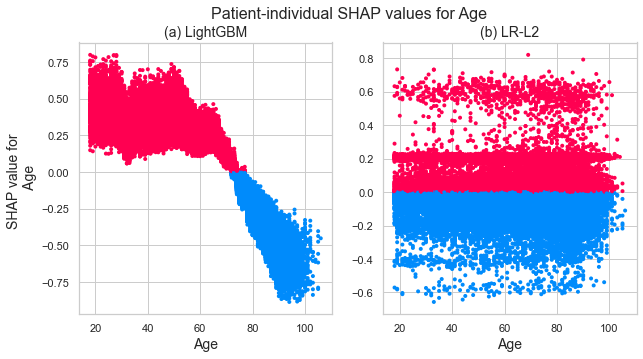

In [412]:
def comparison_scatter_plots(feature='Age', models=['LightGBM', 'L2Regression'], directory=Notebook.SYS_RESULTS_DIR, letters='ab', title=None, save=None):
    sns.set_style('whitegrid')
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    for i, model in enumerate(models):
        explanations = load_filtered_explanations(f'{model}_None_Within-1_with_notes_labs_and_hospital', Notebook.SYS_RESULTS_DIR)
        
        explanations = explanations[:,explanations.feature_names.index(feature)]
        df = pd.concat([pd.Series(explanations.values, name='Value'), pd.Series(explanations.data, name=feature)], axis=1)
        if feature == 'Temperature':
            df = df[df.Temperature > 34]

        df['Colour'] = df.Value.apply(lambda x: x < 0)
        sns.scatterplot(data=df, x=feature, y='Value', hue='Colour', ax=ax[i], legend=False, palette=[shap.plots.colors.red_rgb, shap.plots.colors.blue_rgb], linewidth=0, s=16)
        ax[i].set_title(f'({letters[i]}) {pretty_print_models[model]}')
        points = ax[i].collections[0]
        points.set_rasterized(True)

    ax[0].set_ylabel(f'SHAP value for \n {feature}')
    ax[1].set_ylabel('')

    if not title:
        title = f'Patient-individual SHAP values for {feature}'
    fig.suptitle(title)

    if save:
        fig.savefig(save, bbox_inches='tight', format='svg')

comparison_scatter_plots(save=f'{Notebook.IMAGE_DIR}/shap_scatter_age.svg')

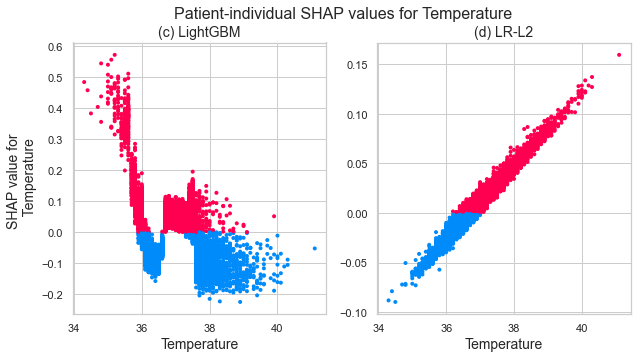

In [414]:
comparison_scatter_plots(feature='Temperature', save=f'{Notebook.IMAGE_DIR}/shap_scatter_temperature.svg', letters='cd')

### Misclassifications

In [110]:
from sklearn.metrics import precision_recall_curve

X_train, X_test, y_train, y_test = get_xy(scii, Estimator_LightGBM, scii.feature_group_combinations['with_notes_labs_and_hospital'])
_, recall, thresholds = precision_recall_curve(y_test, Y_PREDS['LightGBM_None_Within-1_with_notes_labs_and_hospital'])

In [111]:
sci_test[((y_pred_proba < thresholds[np.abs(recall-0.90).argmin()]) & y_test)].AandEPresentingComplaint.value_counts()

NameError: name 'y_pred_proba' is not defined

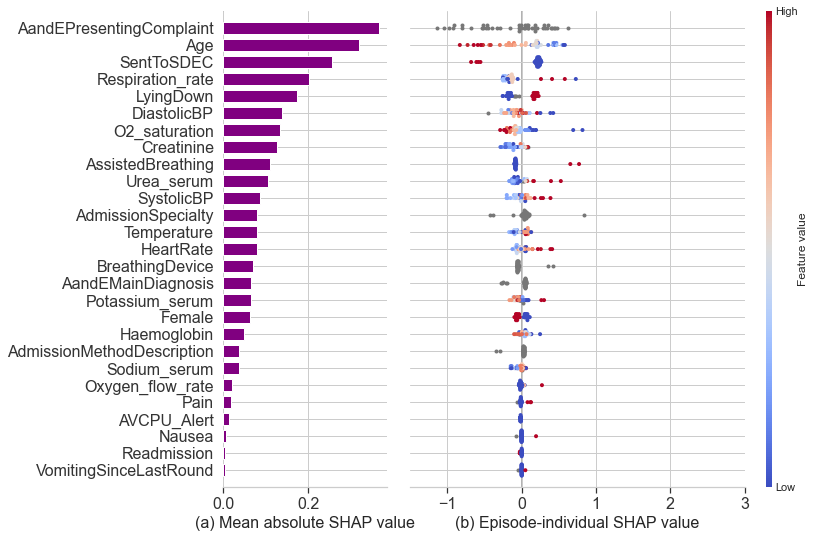

In [ ]:
_, explanations = load_model('LightGBM_None_Within-1_with_notes_labs_and_hospital', Notebook.SYS_RESULTS_DIR)
y_pred_proba = Y_PREDS['LightGBM_None_Within-1_with_notes_labs_and_hospital']
plot_shap_features_joint(
    explanations[np.where((y_pred_proba < thresholds[np.abs(recall-0.95).argmin()]) & y_test)], 
    max_display=250,
    figsize=(12, 8),
    wspace=-0.25,
    bar_aspect=0.04,
    topadjust=0.925,
)

## Time

Vitals: 0.8522452367486444 -> 0.8059654752185418


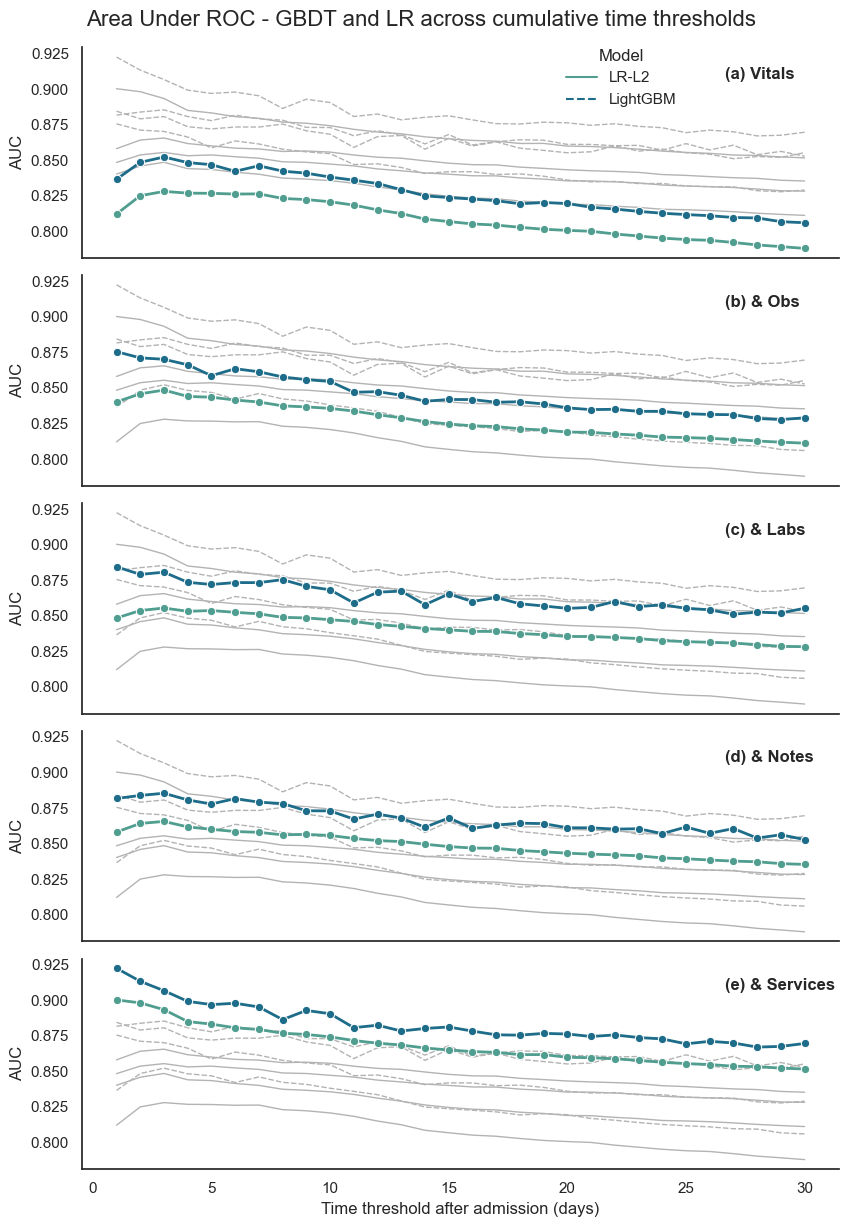

In [162]:
def timeseries_relplot(metrics, save=None):
    df = metrics.copy().rename(columns=dict(estimator='Model'))
    df = df[df.features.isin(select_feature_groups.keys())]
    df.features = df.features.replace(dict(
        news='(a) Vitals',
        news_with_phenotype='(b) & Obs',
        with_labs = '(c) & Labs',
        with_notes_and_labs = '(d) & Notes',
        with_notes_labs_and_hospital = '(e) & Services'
    ))
    df.Model = df.Model.replace(pretty_print_models)
    sns.set_theme(style="white")
    g = sns.relplot(
            data=df, x='outcome_within', y='AUC', hue='Model', col='features', marker='o',
        kind='line', palette='crest', linewidth=2, zorder=5, col_wrap=1, height=2.5, aspect=3.5
    )
    g.legend.legendHandles[1].set_linestyle('--')
    sns.move_legend(g, 'upper right', bbox_to_anchor=(0.7, 0.96), frameon=False)
    subp = [(i, features, ax) for i, (features, ax) in enumerate(g.axes_dict.items())]
    for i, features, ax in subp:
        ax.text(.85, .85, features, transform=ax.transAxes, fontweight='bold')
        line = sns.lineplot(
            data=df, x='outcome_within', y='AUC', units='features', style='Model', 
            estimator=None, color='.7', linewidth=1, ax=ax, legend=False
        )
    g.set_titles("")
    g.set_axis_labels("Time threshold after admission (days)", "AUC")
    g.tight_layout()
    g.fig.suptitle('Area Under ROC - GBDT and LR across cumulative time thresholds', x=0.43)
    g.fig.subplots_adjust(top=0.95)
    if save:
        plt.savefig(save, bbox_inches='tight', format='svg')

    mask = (df.Model == 'LightGBM') & (df.features=='(a) Vitals')
    print(f'Vitals: {df[mask].AUC.max()} -> {df[mask].AUC.min()}')

METRICS_TIME, _ = load_results(Notebook.TIME_RESULTS_DIR)
timeseries_relplot(METRICS_TIME, save=f'{Notebook.IMAGE_DIR}/timeseries_auc.svg')

In [ ]:
model, _ = load_model('LightGBM_None_Within-1_news', Notebook.SYS_RESULTS_DIR)

In [ ]:
from sklearn.calibration import CalibratedClassifierCV
y_crit, y_mort, y_icu = (
    sci_test.derive_critical_event(return_series=True), 
    sci_test.derive_death_within(return_series=True), 
    sci_test.derive_critical_care(return_series=True)
)
y_train_crit, y_train_mort, y_train_icu = (
    sci_train.derive_critical_event(return_series=True), 
    sci_train.derive_death_within(return_series=True), 
    sci_train.derive_critical_care(return_series=True)
)

,Accuracy,Precision,Recall,AP,F2 Score,AUC,AUC_CI
LGBM,,,,,,,
Critical event,0.928391,0.776471,0.022657,0.332553,0.028116,0.779022,0.779 (0.769-0.786)
Mortality only,0.995977,0.247059,0.177966,0.144437,0.188510,0.914547,0.915 (0.868-0.948)
Critical care,0.977888,0.164706,0.016908,0.132036,0.020606,0.837761,0.838 (0.826-0.851)


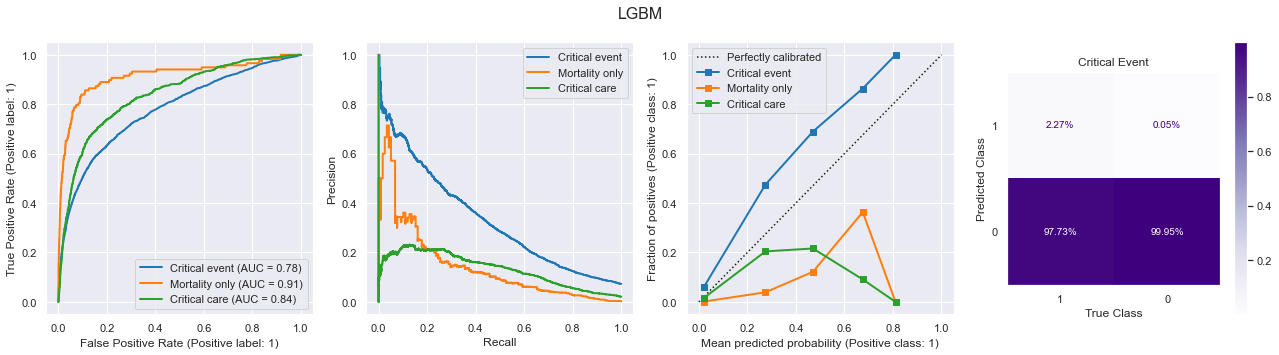

In [ ]:
evaluate_all_outcomes(y_crit, y_mort, y_icu, model.predict(X_test), model.predict_proba(X_test)[:,1], 'LGBM', n_resamples=99)

In [ ]:
X_train, X_test, y_train, y_test = get_xy(scii, Estimator_LightGBM, scii.feature_group_combinations['news'])

### SHAP

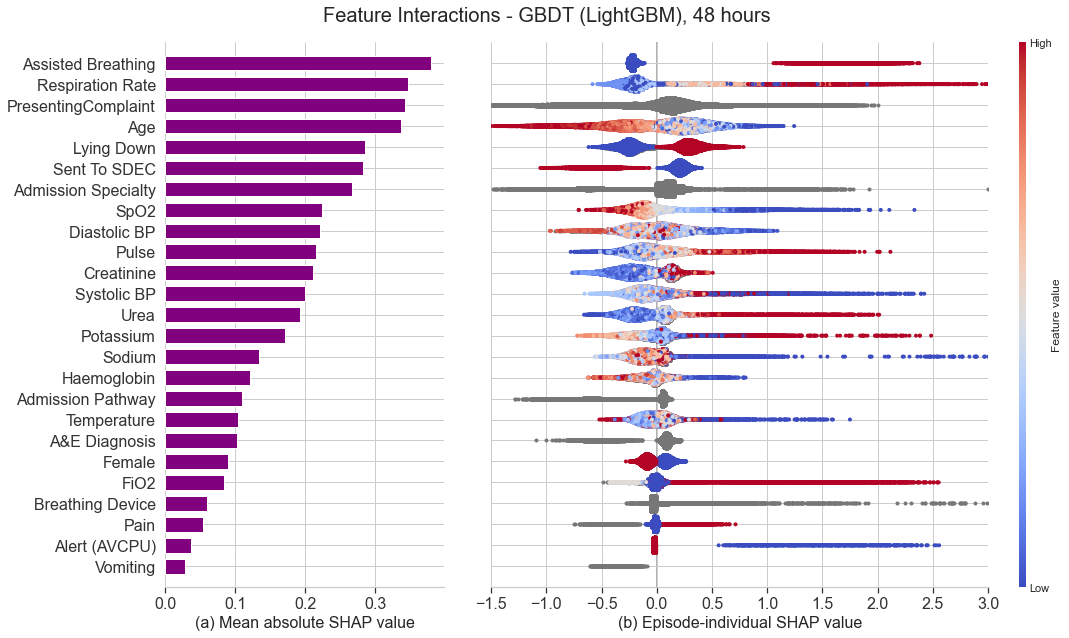

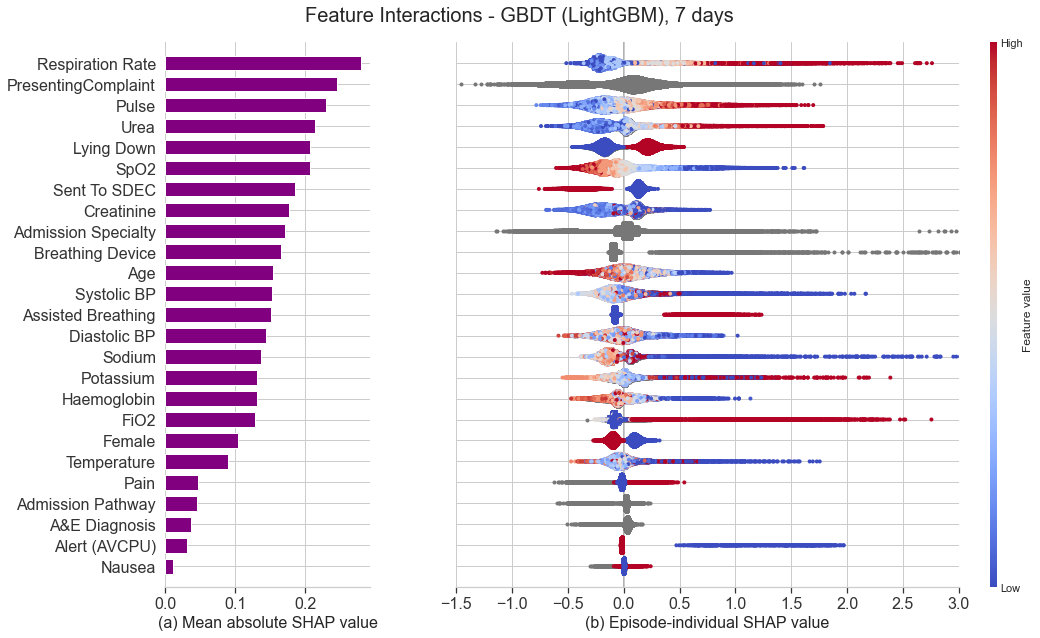

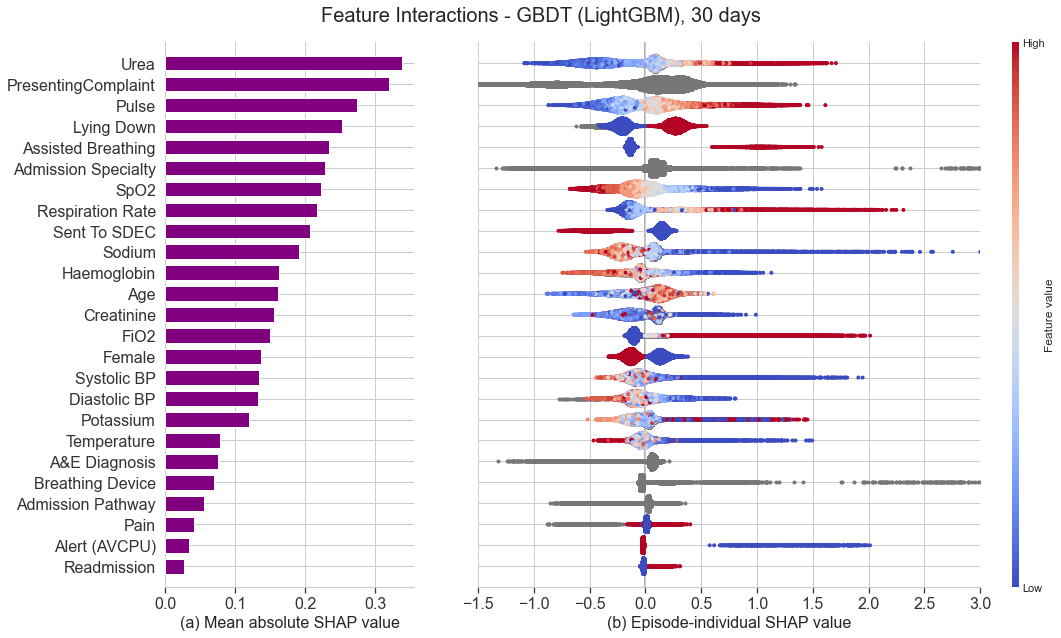

In [ ]:
def lgbm_explanations(name='LightGBM_None_Within-1_with_notes_labs_and_hospital', directory=Notebook.SYS_RESULTS_DIR, save=None, title='Feature Interactions - GBDT (LightGBM)'):
    _, explanations = load_model(name, directory)
    explanations.feature_names = list(map(SCICols.pretty_print_columns.get, explanations.feature_names))
    plot_shap_features_joint(
        explanations, 
        max_display=25,
        figsize=(16, 9),
        wspace=-0.2,
        bar_aspect=0.03,
        topadjust=0.925,
        title=title,
        save=save
    )
    
lgbm_explanations(save=f'{Notebook.IMAGE_DIR}/shap_lgbm_2.png', name='LightGBM_None_Within-2_with_notes_labs_and_hospital', directory=Notebook.TIME_PERSISTED_RESULTS_DIR, title='Feature Interactions - GBDT (LightGBM), 48 hours')
lgbm_explanations(save=f'{Notebook.IMAGE_DIR}/shap_lgbm_7.png', name='LightGBM_None_Within-7_with_notes_labs_and_hospital', directory=Notebook.TIME_PERSISTED_RESULTS_DIR, title='Feature Interactions - GBDT (LightGBM), 7 days')
lgbm_explanations(save=f'{Notebook.IMAGE_DIR}/shap_lgbm_30.png', name='LightGBM_None_Within-30_with_notes_labs_and_hospital', directory=Notebook.TIME_PERSISTED_RESULTS_DIR, title='Feature Interactions - GBDT (LightGBM), 30 days')


## Hyperparameters

In [81]:
def hyperparameters():
   # names = [f'{model}_None_Within-1_{feature}' for model in pretty_print_models.keys() for feature in select_feature_groups.keys()]
    params = [
        dict(
            Model=pretty_print_models[model],
            Features=select_feature_groups[features],
            Param=param.split('__')[1],
            Value=str(round(value, 4)) if type(value) == float else value
        ) for model in pretty_print_models.keys() for features in select_feature_groups.keys()
        for param, value in optuna.load_study(
            study_name =f'{model}_None_Within-1_{features}', storage=f'sqlite:///{Notebook.SYS_RESULTS_DIR}/{model}.db'
        ).best_params.items()
    ]
    return pd.DataFrame(params).pivot(index=['Model', 'Param'], columns='Features', values='Value')[select_feature_groups.values()].fillna('None')

params = hyperparameters()
params

Features                        Vitals      & Obs     & Labs    & Notes  \
Model     Param                                                           
LR        class_weight            None       None       None       None   
LR-EN     C                     0.0592     8.4126     1.1313     8.2228   
          class_weight            None       None       None       None   
          l1_ratio              0.4133      0.355     0.9356     0.5862   
LR-L1     C                     4.1169     2.8061     7.6951     4.4909   
          class_weight            None       None   balanced   balanced   
LR-L2     C                     5.7762     8.6765     9.9825     9.9151   
          class_weight            None       None       None       None   
LightGBM  colsample_bytree      0.6075      0.989     0.5526     0.4737   
          is_unbalance            True      False      False      False   
          min_child_samples        120        147         73         23   
          num_leaves                29         63         16        202   
          reg_alpha             2.6785     0.0402     1.5138     8.8073   
          reg_lambda            9.9052     0.0009     0.0941     0.0024   
          scale_pos_weight        None         53          2          4   
          subsample             0.8714      0.958     0.5702     0.9042   
          subsample_freq             4          4          1          2   
LinearSVM alpha                 0.0032     0.0004     0.0002     0.0011   
          class_weight        balanced       None       None       None   
XGBoost   alpha                    0.0        0.0        0.0        0.0   
          colsample_bytree      0.8389     0.6157     0.6273     0.4414   
          eta                   0.0196     0.0454     0.0231        0.0   
          gamma                    0.0        0.0     0.0005        0.0   
          grow_policy        lossguide  lossguide  lossguide  depthwise   
          lambda                0.0372     0.0019     0.0624      0.157   
          max_depth                  9          7          9          9   
          min_child_weight           8          9          6          5   
          scale_pos_weight           3          6          6         15   
          subsample             0.2505     0.7236     0.4115     0.3563   
          tree_method           approx       hist     approx     approx   

Features                    & Services  
Model     Param                         
LR        class_weight            None  
LR-EN     C                     7.0032  
          class_weight            None  
          l1_ratio              0.8086  
LR-L1     C                     0.2121  
          class_weight            None  
LR-L2     C                     3.5386  
          class_weight            None  
LightGBM  colsample_bytree      0.4804  
          is_unbalance           False  
          min_child_samples        147  
          num_leaves                13  
          reg_alpha             0.0001  
          reg_lambda            9.5277  
          scale_pos_weight           2  
          subsample             0.4902  
          subsample_freq             1  
LinearSVM alpha                 0.0005  
          class_weight            None  
XGBoost   alpha                    0.0  
          colsample_bytree       0.597  
          eta                   0.2193  
          gamma                    0.0  
          grow_policy        lossguide  
          lambda                0.3922  
          max_depth                  3  
          min_child_weight           4  
          scale_pos_weight          81  
          subsample             0.9937  
          tree_method           approx

In [82]:
params.index = params.index.set_levels([f'\\verb|{_}|' for _ in params.index.levels[1]], level=1)

In [83]:
print(params.to_latex(multirow=True, bold_rows=False, column_format='llrrrrr', escape=False, formatters=[lambda x: f'\\verb|{x}|' for _ in range(5)]).replace('\\textbackslash verb', '\\verb').replace('& \\textbf{', '& \\verb{'))

\begin{tabular}{llrrrrr}
\toprule
        & Features &            Vitals &             & Obs &            & Labs &           & Notes &        & Services \\
Model & Param &                   &                   &                   &                   &                   \\
\midrule
LR & \verb|class_weight| &       \verb|None| &       \verb|None| &       \verb|None| &       \verb|None| &       \verb|None| \\
\multirow{3}{*}{LR-EN} & \verb|C| &     \verb|0.0592| &     \verb|8.4126| &     \verb|1.1313| &     \verb|8.2228| &     \verb|7.0032| \\
        & \verb|class_weight| &       \verb|None| &       \verb|None| &       \verb|None| &       \verb|None| &       \verb|None| \\
        & \verb|l1_ratio| &     \verb|0.4133| &      \verb|0.355| &     \verb|0.9356| &     \verb|0.5862| &     \verb|0.8086| \\
\cline{1-7}
\multirow{2}{*}{LR-L1} & \verb|C| &     \verb|4.1169| &     \verb|2.8061| &     \verb|7.6951| &     \verb|4.4909| &     \verb|0.2121| \\
        & \verb|class_weight| &       \ver

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


## Bias

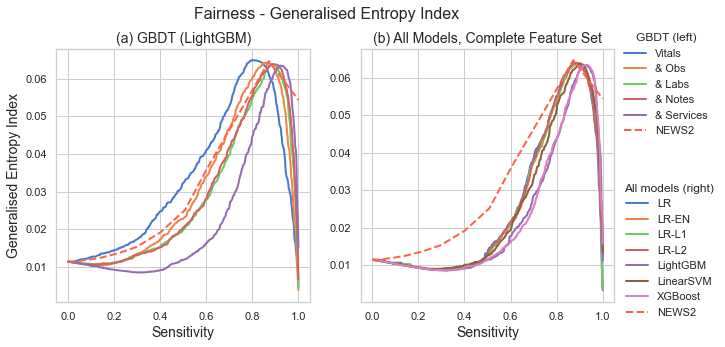

In [443]:
from aif360.sklearn.metrics import generalized_entropy_error, between_group_generalized_entropy_error
def generalized_entropy_curve(y_true, y_pred_proba, prot_attr=None, function=generalized_entropy_error):
    _, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
    if function == generalized_entropy_error:
        r = [function(y_true, np.where(y_pred_proba > _, 1, 0)) for _ in thresholds]
    elif function == between_group_generalized_entropy_error:
        r = [
            between_group_generalized_entropy_error(y_true, np.where(y_pred_proba > _, 1, 0), prot_attr=prot_attr)
            for _ in thresholds]
    return recall[:-1], r

def plot_entropy_curves(y_true, y_preds, prot_attr=None, baseline_key=None, ax=None, palette=sns.color_palette("deep"), title='Equalised Odds', function=generalized_entropy_error):
    no_ax = ax is None
    if no_ax:
        sns.set_style("white")
        plt.rc("axes", titlesize=14)
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    for idx, (modelkey, y_pred_proba) in enumerate(y_preds.items()):
        linestyle = "--" if modelkey == baseline_key else "-"
        color = "tomato" if modelkey == baseline_key else palette[idx]
        x, y = generalized_entropy_curve(y_true, y_pred_proba, prot_attr, function=function)
        sns.lineplot(x=x, y=y, label=modelkey, linewidth=2, linestyle=linestyle, color=color, ax=ax)
    
    ax.legend(loc="upper right")
    # sns.move_legend(ax, "center left", bbox_to_anchor=(1, 0.5))
    ax.set_title(title)
    ax.set_xlabel("Sensitivity")
    if function == generalized_entropy_error:
        ax.set_ylabel("Generalised Entropy Index")
    elif function == between_group_generalized_entropy_error:
        ax.set_ylabel("Between-Group Unfairness")

def entropy_comparison(metrics, y_preds, prot_attr=None, save=None, function=generalized_entropy_error, title='Fairness - Generalised Entropy Index'):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.set_style("whitegrid")
    for _ in ax:
        _.set_box_aspect(1)
    
    y_test = sci_test.derive_critical_event(within=1, return_series=True).loc[y_preds.index]
    baseline_news = {'NEWS2': sci_test.loc[y_test.index, 'NEWS_score']}
    y_preds_l, y_preds_r = model_preds_across_features(metrics, y_preds, 'LightGBM'), all_model_preds(metrics, y_preds)

    plot_entropy_curves(y_test, y_preds_l | baseline_news, ax=ax[0], title='(a) GBDT (LightGBM)', baseline_key='NEWS2', palette=sns.color_palette('muted'), function=function, prot_attr=prot_attr)
    plot_entropy_curves(y_test, y_preds_r | baseline_news, ax=ax[1], title='(b) All Models, Complete Feature Set', baseline_key='NEWS2', palette=sns.color_palette('muted'), function=function, prot_attr=prot_attr)

    sns.move_legend(ax[0], "upper left", bbox_to_anchor=(2.2, 1.1), frameon=False, title='GBDT (left)')
    sns.move_legend(ax[1], "lower left", bbox_to_anchor=(1, -0.1), frameon=False, title='All models (right)')
    ax[1].set_ylabel(None)
   # fig.tight_layout(h_pad=0.5, w_pad=0.5)
    fig.subplots_adjust(top=0.9)
    fig.suptitle(title)
    if save:
        plt.savefig(save, bbox_inches='tight', format='svg')
entropy_comparison(METRICS, Y_PREDS, save=f'{Notebook.IMAGE_DIR}/entropy.svg')        

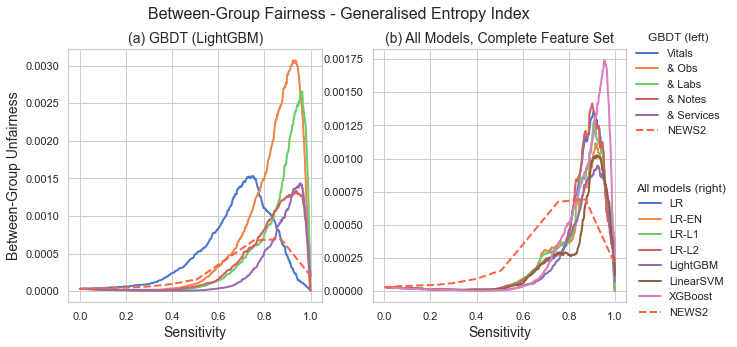

In [444]:
entropy_comparison(METRICS, Y_PREDS, function=between_group_generalized_entropy_error, prot_attr=sci_test.derive_critical_event(return_series=True).set_axis(sci_test[['Female', 'AgeBand']]).index, save=f'{Notebook.IMAGE_DIR}/entropy_between.svg', title='Between-Group Fairness - Generalised Entropy Index')

In [430]:
from aif360.sklearn.metrics.metrics import intersection, smoothed_base_rate
from itertools import permutations

def soft_base_rate(y_true, y_pred=None, *, concentration=1.0, pos_label=1, sample_weight=None):
    return (np.sum(y_true) + concentration)/(y_true.shape[0] + concentration)

def soft_selection_rate(y_true, y_pred, *, concentration=1.0, pos_label=1, sample_weight=None):
    return soft_base_rate(y_pred, concentration=concentration, pos_label=pos_label, sample_weight=sample_weight)

def soft_edf(y_true, y_pred=None, *, prot_attr=None, pos_label=1, concentration=1.0, sample_weight=None):
    rate = soft_base_rate if y_pred is None else soft_selection_rate
    sbr = intersection(rate, y_true, y_pred, prot_attr=prot_attr)
    logsbr = np.log(sbr)
    pos_ratio = max(abs(i - j) for i, j in permutations(logsbr, 2))
    lognegsbr = np.log(1 - np.array(sbr))
    neg_ratio = max(abs(i - j) for i, j in permutations(lognegsbr, 2))
    return max(pos_ratio, neg_ratio)

def soft_df_bias_amplification(y_true, y_pred, prot_attr, pos_label=1, concentration=1.0, sample_weight=None):
    eps_true = soft_edf(y_true, prot_attr=prot_attr, pos_label=pos_label,
                            concentration=concentration,
                            sample_weight=sample_weight)
    eps_pred = soft_edf(y_true, y_pred, prot_attr=prot_attr,
                            pos_label=pos_label, concentration=concentration,
                            sample_weight=sample_weight)
    return eps_pred - eps_true

def bootstrap_bias_amplification(y_true, y_score, prot_attr, n_resamples=99):
    center = soft_df_bias_amplification(y_true, y_score, prot_attr)
    res = st.bootstrap(
        data=(y_true.to_numpy(), y_score.to_numpy(), prot_attr.to_numpy()),
        statistic=soft_df_bias_amplification,
        confidence_level=0.95,
        method="percentile",
        n_resamples=n_resamples,
        vectorized=False,
        paired=True,
        random_state=42,
    )
    return res.confidence_interval.low, center, res.confidence_interval.high

In [550]:
def calc_bias_amplifications():
    df = sci_test[sci_test.AgeBand != '16 and Under'].copy()
    y_test = df.CriticalEvent
    prot_attrs = dict(
        Age=df.AgeBand,
        Sex=df.Female,
        Both=y_test.set_axis(df[['AgeBand', 'Female']]).index,
    )

    metrics = METRICS[(METRICS.resampler=='None')&(METRICS.features.isin(select_feature_groups.keys()))].copy()
    get_dict = lambda low, mid, high: dict(
            Bias_Amp = mid,
            Bias_Amp_Lower = low,
            Bias_Amp_Upper = high
        )
  
    for _ in metrics.to_dict(orient='records'):
        for attr_key, prot_attr in prot_attrs.items():
            y_pred_proba = Y_PREDS.loc[df.index, _['name']]
            print(y_test)
            return bootstrap_bias_amplification(
                y_test, 
                y_pred_proba,
                prot_attr, 
                n_resamples=9
            )

    # df['Bias'] = df.Bias_Amp.map('{:.3f}'.format) + ' (' + df.Bias_Amp_Lower.map('{:.3f}'.format) + ' - ' + df.Bias_Amp_Upper.map('{:.3f}'.format) + ')'
    # print(f'Median: {df[df.protected=="Both"].Bias_Amp.median()}')

    # return df.pivot(index=['features', 'estimator'], columns=['protected'], values='Bias')[['Sex', 'Age', 'Both']].loc[select_feature_groups.values()]


calc_bias_amplifications()

133137    False
133924    False
118771    False
136690    False
16992     False
          ...  
29619     False
41774     False
140229    False
79460     False
17697     False
Name: CriticalEvent, Length: 38879, dtype: bool


(-0.1163596883365039, 0.0822665858801983, 0.2537677437646345)

In [431]:
def calc_bias_amplifications():
    df = sci_test[sci_test.AgeBand != '16 and Under'].copy()
    y_test = df.CriticalEvent
    prot_attrs = dict(
        Age=df.AgeBand,
        Sex=df.Female,
        Both=y_test.set_axis(df[['AgeBand', 'Female']]).index,
    )

    metrics = METRICS[(METRICS.resampler=='None')&(METRICS.features.isin(select_feature_groups.keys()))].copy()
    get_dict = lambda low, mid, high: dict(
            Bias_Amp = mid,
            Bias_Amp_Lower = low,
            Bias_Amp_Upper = high
        )
  
    df = pd.DataFrame((
        dict(
            name=_['name'],
            estimator=pretty_print_models[_['estimator']],
            features=select_feature_groups[_['features']],
            protected=attr_key
        )| get_dict(*bootstrap_bias_amplification(
            y_test, 
            Y_PREDS.loc[df.index, _['name']],
            prot_attr, 
            n_resamples=9
        )) for _ in metrics.to_dict(orient='records') for attr_key, prot_attr in prot_attrs.items()
    ))

    df['Bias'] = df.Bias_Amp.map('{:.3f}'.format) + ' (' + df.Bias_Amp_Lower.map('{:.3f}'.format) + ' - ' + df.Bias_Amp_Upper.map('{:.3f}'.format) + ')'
    print(f'Median: {df[df.protected=="Both"].Bias_Amp.median()}')

    return df.pivot(index=['features', 'estimator'], columns=['protected'], values='Bias')[['Sex', 'Age', 'Both']].loc[select_feature_groups.values()]


df = calc_bias_amplifications()
df

Median: -0.5902660919046232


protected                                  Sex                       Age  \
features   estimator                                                       
Vitals     LR         -0.239 (-0.298 - -0.125)    0.080 (-0.114 - 0.246)   
           LR-EN      -0.238 (-0.298 - -0.124)    0.082 (-0.116 - 0.254)   
           LR-L1      -0.239 (-0.298 - -0.125)    0.080 (-0.114 - 0.246)   
           LR-L2      -0.239 (-0.298 - -0.125)    0.080 (-0.114 - 0.247)   
           LightGBM   -0.244 (-0.296 - -0.134)    0.007 (-0.194 - 0.186)   
           LinearSVM  -0.252 (-0.289 - -0.112)    0.176 (-0.016 - 0.343)   
           XGBoost    -0.240 (-0.287 - -0.133)    0.070 (-0.132 - 0.258)   
& Obs      LR            0.053 (0.022 - 0.185)  -0.508 (-0.672 - -0.368)   
           LR-EN         0.053 (0.022 - 0.185)  -0.509 (-0.672 - -0.368)   
           LR-L1         0.052 (0.021 - 0.184)  -0.509 (-0.671 - -0.368)   
           LR-L2         0.053 (0.022 - 0.185)  -0.509 (-0.672 - -0.368)   
           LightGBM     0.010 (-0.017 - 0.118)  -0.343 (-0.505 - -0.214)   
           LinearSVM  -0.144 (-0.185 - -0.038)  -0.717 (-0.917 - -0.548)   
           XGBoost     -0.018 (-0.052 - 0.101)  -0.322 (-0.477 - -0.171)   
& Labs     LR            0.074 (0.045 - 0.204)  -0.526 (-0.678 - -0.385)   
           LR-EN         0.074 (0.045 - 0.205)  -0.525 (-0.677 - -0.385)   
           LR-L1         0.095 (0.066 - 0.226)  -0.515 (-0.696 - -0.341)   
           LR-L2         0.075 (0.045 - 0.205)  -0.525 (-0.677 - -0.385)   
           LightGBM      0.036 (0.008 - 0.145)  -0.345 (-0.482 - -0.204)   
           LinearSVM   -0.047 (-0.085 - 0.049)  -0.631 (-0.768 - -0.448)   
           XGBoost     -0.014 (-0.041 - 0.106)  -0.354 (-0.499 - -0.208)   
& Notes    LR            0.068 (0.046 - 0.202)  -0.500 (-0.658 - -0.359)   
           LR-EN         0.072 (0.051 - 0.208)  -0.500 (-0.655 - -0.360)   
           LR-L1         0.078 (0.054 - 0.214)  -0.523 (-0.685 - -0.387)   
           LR-L2         0.072 (0.051 - 0.207)  -0.500 (-0.656 - -0.360)   
           LightGBM      0.017 (0.003 - 0.137)  -0.337 (-0.495 - -0.184)   
           LinearSVM   -0.047 (-0.084 - 0.063)  -0.682 (-0.858 - -0.501)   
           XGBoost     -0.058 (-0.087 - 0.062)  -0.209 (-0.403 - -0.079)   
& Services LR            0.048 (0.016 - 0.153)  -0.476 (-0.604 - -0.318)   
           LR-EN         0.054 (0.024 - 0.160)  -0.482 (-0.606 - -0.328)   
           LR-L1         0.053 (0.024 - 0.167)  -0.479 (-0.609 - -0.333)   
           LR-L2         0.057 (0.027 - 0.163)  -0.482 (-0.605 - -0.329)   
           LightGBM     0.011 (-0.019 - 0.101)  -0.284 (-0.400 - -0.131)   
           LinearSVM  -0.128 (-0.168 - -0.037)  -0.609 (-0.775 - -0.421)   
           XGBoost      0.003 (-0.033 - 0.100)  -0.282 (-0.415 - -0.125)   

protected                                 Both  
features   estimator                            
Vitals     LR         -0.234 (-0.449 - -0.045)  
           LR-EN      -0.231 (-0.448 - -0.040)  
           LR-L1      -0.234 (-0.450 - -0.045)  
           LR-L2      -0.234 (-0.449 - -0.044)  
           LightGBM   -0.320 (-0.520 - -0.110)  
           LinearSVM   -0.125 (-0.346 - 0.077)  
           XGBoost    -0.250 (-0.447 - -0.043)  
& Obs      LR         -0.631 (-0.863 - -0.416)  
           LR-EN      -0.632 (-0.864 - -0.417)  
           LR-L1      -0.632 (-0.863 - -0.417)  
           LR-L2      -0.632 (-0.864 - -0.417)  
           LightGBM   -0.477 (-0.692 - -0.299)  
           LinearSVM  -1.037 (-1.243 - -0.795)  
           XGBoost    -0.507 (-0.716 - -0.319)  
& Labs     LR         -0.620 (-0.842 - -0.408)  
           LR-EN      -0.618 (-0.840 - -0.406)  
           LR-L1      -0.597 (-0.841 - -0.383)  
           LR-L2      -0.619 (-0.840 - -0.406)  
           LightGBM   -0.434 (-0.639 - -0.244)  
           LinearSVM  -0.684 (-0.890 - -0.403)  
           XGBoost    -0.530 (-0.741 - -0.337)  
& Notes    LR         -0.590 (-0.807 - -0.368)  
           

In [433]:
print(df.loc[select_feature_groups.values()].to_latex(bold_rows=True, multicolumn=True, multirow=True, column_format='llrrr'))

\begin{tabular}{llrrr}
\toprule
           & \textbf{protected} &                       Sex &                       Age &                      Both \\
\textbf{features} & \textbf{estimator} &                           &                           &                           \\
\midrule
\multirow{7}{*}{\textbf{Vitals}} & \textbf{LR} &  -0.239 (-0.298 - -0.125) &    0.080 (-0.114 - 0.246) &  -0.234 (-0.449 - -0.045) \\
           & \textbf{LR-EN} &  -0.238 (-0.298 - -0.124) &    0.082 (-0.116 - 0.254) &  -0.231 (-0.448 - -0.040) \\
           & \textbf{LR-L1} &  -0.239 (-0.298 - -0.125) &    0.080 (-0.114 - 0.246) &  -0.234 (-0.450 - -0.045) \\
           & \textbf{LR-L2} &  -0.239 (-0.298 - -0.125) &    0.080 (-0.114 - 0.247) &  -0.234 (-0.449 - -0.044) \\
           & \textbf{LightGBM} &  -0.244 (-0.296 - -0.134) &    0.007 (-0.194 - 0.186) &  -0.320 (-0.520 - -0.110) \\
           & \textbf{LinearSVM} &  -0.252 (-0.289 - -0.112) &    0.176 (-0.016 - 0.343) &   -0.125 (-0.346 - 0.077) \

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


## Cross-Validation

To make the reviewers happy

In [112]:
from systematic_comparison import study_grid_from_args, get_xy, PipelineFactory
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import cross_validate
from utils.evaluation import METRICS as cv_metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import brier_score_loss

def run_pretuned(estimator, resampler, scii, feature_group, features, outcome_within, cv=4, cv_jobs=4):
    X, y = get_xy(scii, estimator, features, outcome_within, outcome='CriticalEvent', split=False)

    params = optuna.load_study(
            study_name =f'{estimator._name}_None_Within-1_{feature_group}', storage=f'sqlite:///{Notebook.SYS_RESULTS_DIR}/{estimator._name}.db'
        ).best_params

    pipeline_factory = PipelineFactory(
        estimator=estimator, resampler=resampler, X_train=X, y_train=y,
    )

    # model = pipeline_factory(**params)

    model = CalibratedClassifierCV(
        pipeline_factory(**params), cv=6, method="isotonic", n_jobs=1,
    )

    score = cross_validate(
        model, X, y, scoring=cv_metrics | dict(Brier='neg_brier_score'),
        cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=123), n_jobs=cv_jobs, 
    )

    return score

#run_pretuned(**grid[0], scii=scii)

In [119]:
from tqdm import tqdm

RESULTS = []
def run_pretuned_all():
    grid = [_ for model in pretty_print_models.keys() for _ in study_grid_from_args(dict(
        models=model,
        time_thresholds=False,
        select_features=True,
        resamplers=None
    ), scii) if _['resampler'] is None]

    for _ in tqdm(grid):
        result = run_pretuned(**_, scii=scii)
        RESULTS.append(
            pd.DataFrame.from_dict(result).assign(Model=_['estimator']._name, Features=_['feature_group'])
        )

    return pd.concat(RESULTS).groupby(['Features', 'Model']).mean()

run_pretuned_all()

100%|██████████| 70/70 [8:25:34<00:00, 433.35s/it]    


fit_time  \
Features                            Model                               
news                                ElasticNetRegression    10.454198   
                                    L1Regression            10.089646   
                                    L2Regression             1.318938   
                                    LightGBM                10.592399   
                                    LinearSVM                1.538568   
                                    LogisticRegression       1.409821   
                                    XGBoost                 45.809389   
news_scores                         ElasticNetRegression     4.370008   
                                    L1Regression             4.419767   
                                    L2Regression             0.968520   
                                    LightGBM                 6.051712   
                                    LinearSVM                1.864838   
                                    LogisticRegression       1.048364   
                                    XGBoost                 12.989082   
news_scores_with_phenotype          ElasticNetRegression   589.286098   
                                    L1Regression           486.958312   
                                    L2Regression            20.832169   
                                    LightGBM                26.262794   
                                    LinearSVM                2.218559   
                                    LogisticRegression      28.396617   
                                    XGBoost                 27.005372   
news_with_phenotype                 ElasticNetRegression   517.389750   
                                    L1Regression           879.959882   
                                    L2Regression            26.647881   
                                    LightGBM                18.902017   
                                    LinearSVM                2.405880   
                                    LogisticRegression      23.770525   
                                    XGBoost                 22.398562   
scores_with_labs                    ElasticNetRegression   741.229524   
                                    L1Regression           592.218954   
                                    L2Regression            27.841698   
                                    LightGBM                22.212723   
                                    LinearSVM                2.640125   
                                    LogisticRegression      39.625049   
                                    XGBoost                 83.416919   
scores_with_notes_and_labs          ElasticNetRegression  1286.635588   
                                    L1Regression          2105.346811   
                                    L2Regression           125.273576   
                                    LightGBM                16.903149   
                                    LinearSVM                4.909660   
                                    LogisticRegression     251.165168   
                                    XGBoost                 26.665760   
scores_with_notes_labs_and_hospital ElasticNetRegression  1564.076569   
                                    L1Regression          3856.968399   
                                    L2Regression           204.152994   
                                    LightGBM                22.907395   
                                    LinearSVM                6.644230   
                                    LogisticRegression     389.045186   
                                    XGBoost                 38.581303   
with_labs                           ElasticNetRegression   818.095484   
                                    L1Regression           962.866594   
                                    L2Regression            35.911251   
                                    LightGBM                13.152790   
                                    LinearSVM 

In [111]:
import sklearn
sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_

In [92]:
cv_df

fit_time  \
Features                            Model                              
news                                ElasticNetRegression    1.898045   
                                    L1Regression            1.773392   
                                    L2Regression            0.253841   
                                    LightGBM                1.948760   
                                    LinearSVM               0.246036   
                                    LogisticRegression      0.274263   
                                    XGBoost                 9.806043   
news_scores                         ElasticNetRegression    0.847454   
                                    L1Regression            0.839648   
                                    L2Regression            0.179643   
                                    LightGBM                1.304992   
                                    LinearSVM               0.374911   
                                    LogisticRegression      0.171844   
                                    XGBoost                 2.964145   
news_scores_with_phenotype          ElasticNetRegression  116.988761   
                                    L1Regression           98.715141   
                                    L2Regression            4.253273   
                                    LightGBM                4.975837   
                                    LinearSVM               0.394440   
                                    LogisticRegression      5.655505   
                                    XGBoost                 5.549515   
news_with_phenotype                 ElasticNetRegression  104.318006   
                                    L1Regression          154.089163   
                                    L2Regression            5.176381   
                                    LightGBM                3.652225   
                                    LinearSVM               0.386626   
                                    LogisticRegression      4.262098   
                                    XGBoost                 4.683296   
scores_with_labs                    ElasticNetRegression  160.128673   
                                    L1Regression          120.798128   
                                    L2Regression            5.289196   
                                    LightGBM                4.189613   
                                    LinearSVM               0.464737   
                                    LogisticRegression      5.717621   
                                    XGBoost                17.591708   
scores_with_notes_and_labs          ElasticNetRegression  261.831528   
                                    L1Regression          364.564859   
                                    L2Regression           25.864942   
                                    LightGBM                3.087624   
                                    LinearSVM               0.827929   
                                    LogisticRegression     36.451970   
                                    XGBoost                 5.623430   
scores_with_notes_labs_and_hospital ElasticNetRegression  337.978879   
                                    L1Regression          819.783884   
                                    L2Regression           41.842466   
                                    LightGBM                4.239366   
                                    LinearSVM               1.106675   
                                    LogisticRegression     62.519024   
                                    XGBoost                 7.902223   
with_labs                           ElasticNetRegression  171.232398   
                                    L1Regression          187.356273   
                                    L2Regression            7.053044   
                                    LightGBM                2.503256   
                                    LinearSVM               0.488159   
                            

In [96]:
df[(df.Features=='with_notes_labs_and_hospital') & (df.Model=='LightGBM')]

,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_AP,test_F2 Score,test_AUC,Model,Features
0,10.895743,4.480304,0.978920,0.732240,0.185339,0.414341,0.217886,0.902167,LightGBM,with_notes_labs_and_hospital
1,10.802017,4.535359,0.980373,0.760000,0.262431,0.468754,0.301971,0.921770,LightGBM,with_notes_labs_and_hospital
2,10.833259,4.714632,0.982487,0.850909,0.323651,0.524443,0.369435,0.920976,LightGBM,with_notes_labs_and_hospital
3,10.848882,4.589657,0.980967,0.688946,0.370678,0.511824,0.408412,0.920805,LightGBM,with_notes_labs_and_hospital


In [87]:
# df = pd.concat(RESULTS)
# df.to_csv('overnighted_pretuned.csv')